a. 在Day3的实验中，感知机的层数是否是越深越好？感知机每一层的维度是否是越大越好？它们的变化会对网络训练的结果造成何种影响？提出自己的假设并设计小实验来初步论证。

感知机的层数和每一层的维度对网络训练的结果会有一定的影响，但并不是越深和越大就一定会得到更好的结果。增加感知机的层数和每一层的维度可能导致过拟合。

保持原有的MLP模型不变，作为Baseline模型。增加感知机的层数和每一层的维度，并比较不同模型的训练性能和测试准确率。

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# 加载 FashionMNIST 数据集
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

class MLP(nn.Module):
    def __init__(self, hidden_layers=1, hidden_dim=128):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, hidden_dim)
        self.hidden_layers = hidden_layers
        self.hidden_dim = hidden_dim
        for i in range(hidden_layers-1):
            setattr(self, f"fc{i+2}", nn.Linear(hidden_dim, hidden_dim))
        self.fc_out = nn.Linear(hidden_dim, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for i in range(self.hidden_layers):
            x = torch.relu(getattr(self, f"fc{i+1}")(x))
        x = self.fc_out(x)
        return x

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / len(train_loader), correct / total

def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), correct / total

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Baseline模型，感知机层数为1，维度为128
model_baseline = MLP(hidden_layers=1, hidden_dim=128).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_baseline.parameters(), lr=0.01)

# 训练Baseline模型
num_epochs = 10
train_losses_baseline = []
train_accuracies_baseline = []
test_losses_baseline = []
test_accuracies_baseline = []
for epoch in range(num_epochs):
    train_loss, train_acc = train(model_baseline, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test(model_baseline, test_loader, criterion, device)
    train_losses_baseline.append(train_loss)
    train_accuracies_baseline.append(train_acc)
    test_losses_baseline.append(test_loss)
    test_accuracies_baseline.append(test_acc)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# 实验模型，增加感知机层数和维度
hidden_layers = [2, 3, 4]
hidden_dims = [128, 256, 512]
train_losses_exp = {}
train_accuracies_exp = {}
test_losses_exp = {}
test_accuracies_exp = {}
for layers in hidden_layers:
    for dim in hidden_dims:
        model_exp = MLP(hidden_layers=layers, hidden_dim=dim).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model_exp.parameters(), lr=0.01)
        train_losses = []
        train_accuracies = []
        test_losses = []
        test_accuracies = []
        for epoch in range(num_epochs):
            train_loss, train_acc = train(model_exp, train_loader, criterion, optimizer, device)
            test_loss, test_acc = test(model_exp, test_loader, criterion, device)
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            test_losses.append(test_loss)
            test_accuracies.append(test_acc)
            print(f"Layers: {layers}, Dimension: {dim}, Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
        train_losses_exp[(layers, dim)] = train_losses
        train_accuracies_exp[(layers, dim)] = train_accuracies
        test_losses_exp[(layers, dim)] = test_losses
        test_accuracies_exp[(layers, dim)] = test_accuracies

# 保存实验结果
torch.save({
    'train_losses_baseline': train_losses_baseline,
    'train_accuracies_baseline': train_accuracies_baseline,
    'test_losses_baseline': test_losses_baseline,
    'test_accuracies_baseline': test_accuracies_baseline,
    'train_losses_exp': train_losses_exp,
    'train_accuracies_exp': train_accuracies_exp,
    'test_losses_exp': test_losses_exp,
    'test_accuracies_exp': test_accuracies_exp
}, 'experiment_results.pth')

Epoch 1/10, Train Loss: 0.7928, Train Acc: 0.7479, Test Loss: 0.5874, Test Acc: 0.7880
Epoch 2/10, Train Loss: 0.5218, Train Acc: 0.8165, Test Loss: 0.5150, Test Acc: 0.8159
Epoch 3/10, Train Loss: 0.4747, Train Acc: 0.8321, Test Loss: 0.4885, Test Acc: 0.8234
Epoch 4/10, Train Loss: 0.4487, Train Acc: 0.8415, Test Loss: 0.4759, Test Acc: 0.8278
Epoch 5/10, Train Loss: 0.4300, Train Acc: 0.8482, Test Loss: 0.4516, Test Acc: 0.8364
Epoch 6/10, Train Loss: 0.4157, Train Acc: 0.8532, Test Loss: 0.4574, Test Acc: 0.8330
Epoch 7/10, Train Loss: 0.4030, Train Acc: 0.8572, Test Loss: 0.4346, Test Acc: 0.8420
Epoch 8/10, Train Loss: 0.3920, Train Acc: 0.8616, Test Loss: 0.4249, Test Acc: 0.8458
Epoch 9/10, Train Loss: 0.3832, Train Acc: 0.8649, Test Loss: 0.4177, Test Acc: 0.8491
Epoch 10/10, Train Loss: 0.3747, Train Acc: 0.8679, Test Loss: 0.4147, Test Acc: 0.8522
Layers: 2, Dimension: 128, Epoch 1/10, Train Loss: 0.9953, Train Acc: 0.6798, Test Loss: 0.6231, Test Acc: 0.7695
Layers: 2, Dime

b. 在Day3的神经网络中，训练轮数的设置可能会对最终的结果产生一定的影响。在这两道题中，训练轮数设置为多少比较合适？
不断增加直到模型性能不再明显提升为止

21次

Test Accuracy: 11.15%


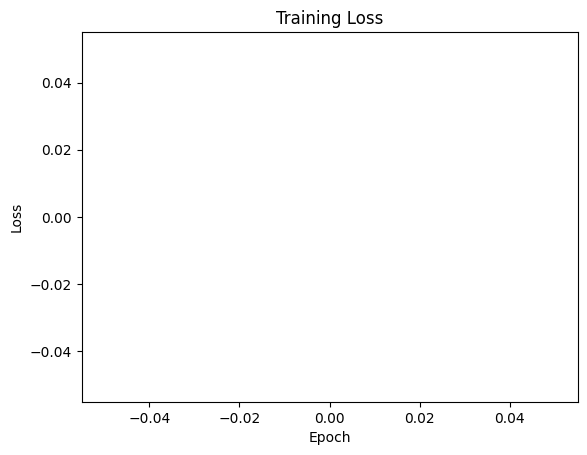

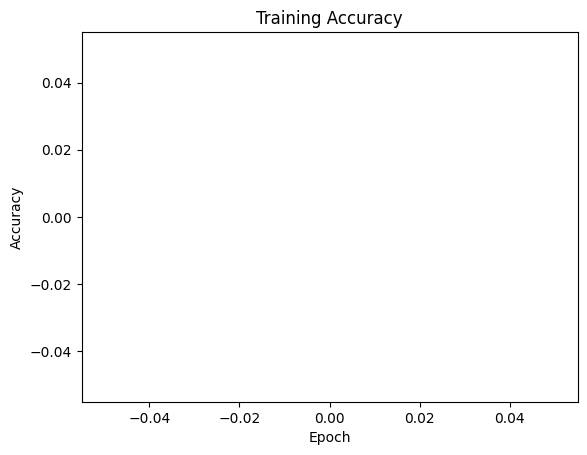

Epoch [1/1], Step [100/938], Loss: 2.0569, Accuracy: 40.62%
Epoch [1/1], Step [200/938], Loss: 1.4653, Accuracy: 56.25%
Epoch [1/1], Step [300/938], Loss: 0.9922, Accuracy: 75.00%
Epoch [1/1], Step [400/938], Loss: 0.9396, Accuracy: 73.44%
Epoch [1/1], Step [500/938], Loss: 0.6242, Accuracy: 82.81%
Epoch [1/1], Step [600/938], Loss: 0.5491, Accuracy: 84.38%
Epoch [1/1], Step [700/938], Loss: 0.5458, Accuracy: 81.25%
Epoch [1/1], Step [800/938], Loss: 0.5567, Accuracy: 84.38%
Epoch [1/1], Step [900/938], Loss: 0.4939, Accuracy: 84.38%
Validation Loss: 0.6404
Test Accuracy: 76.5%


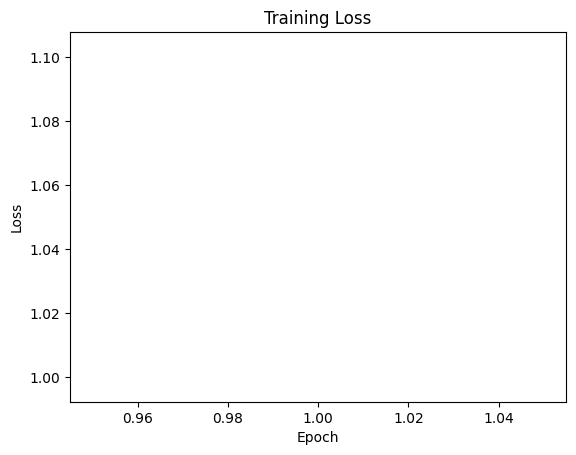

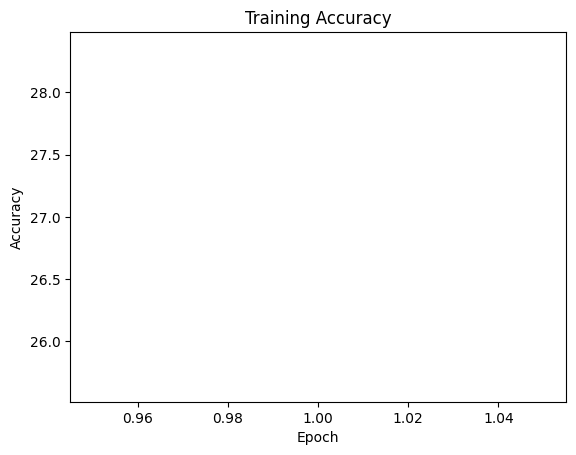

Epoch [1/2], Step [100/938], Loss: 2.0001, Accuracy: 37.50%
Epoch [1/2], Step [200/938], Loss: 1.2677, Accuracy: 64.06%
Epoch [1/2], Step [300/938], Loss: 0.9049, Accuracy: 73.44%
Epoch [1/2], Step [400/938], Loss: 0.7227, Accuracy: 76.56%
Epoch [1/2], Step [500/938], Loss: 0.7232, Accuracy: 79.69%
Epoch [1/2], Step [600/938], Loss: 0.6103, Accuracy: 81.25%
Epoch [1/2], Step [700/938], Loss: 0.7318, Accuracy: 70.31%
Epoch [1/2], Step [800/938], Loss: 0.8177, Accuracy: 73.44%
Epoch [1/2], Step [900/938], Loss: 0.6280, Accuracy: 75.00%
Validation Loss: 0.6218
Epoch [2/2], Step [100/938], Loss: 0.6519, Accuracy: 78.12%
Epoch [2/2], Step [200/938], Loss: 0.6234, Accuracy: 75.00%
Epoch [2/2], Step [300/938], Loss: 0.6024, Accuracy: 73.44%
Epoch [2/2], Step [400/938], Loss: 0.6251, Accuracy: 79.69%
Epoch [2/2], Step [500/938], Loss: 0.5309, Accuracy: 78.12%
Epoch [2/2], Step [600/938], Loss: 0.4105, Accuracy: 87.50%
Epoch [2/2], Step [700/938], Loss: 0.5224, Accuracy: 79.69%
Epoch [2/2], Ste

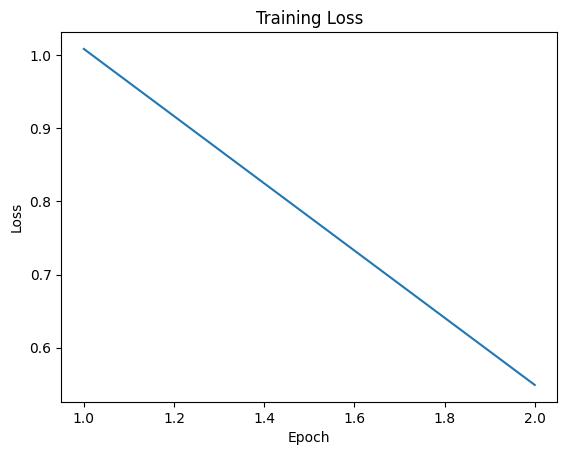

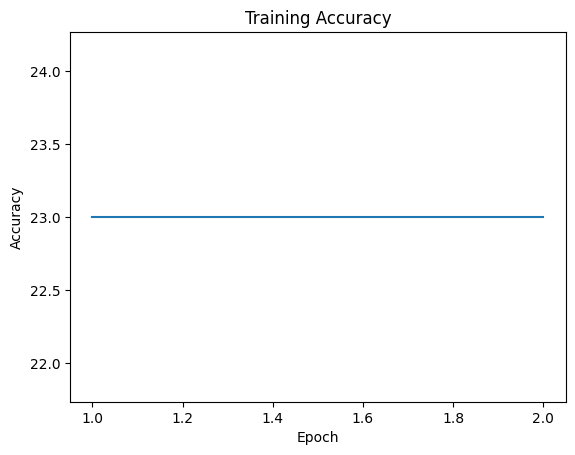

Epoch [1/3], Step [100/938], Loss: 2.0260, Accuracy: 39.06%
Epoch [1/3], Step [200/938], Loss: 1.3971, Accuracy: 56.25%
Epoch [1/3], Step [300/938], Loss: 1.0652, Accuracy: 67.19%
Epoch [1/3], Step [400/938], Loss: 0.8687, Accuracy: 71.88%
Epoch [1/3], Step [500/938], Loss: 0.7949, Accuracy: 71.88%
Epoch [1/3], Step [600/938], Loss: 0.7882, Accuracy: 71.88%
Epoch [1/3], Step [700/938], Loss: 0.8189, Accuracy: 68.75%
Epoch [1/3], Step [800/938], Loss: 0.6109, Accuracy: 76.56%
Epoch [1/3], Step [900/938], Loss: 0.7033, Accuracy: 82.81%
Validation Loss: 0.6397
Epoch [2/3], Step [100/938], Loss: 0.5926, Accuracy: 78.12%
Epoch [2/3], Step [200/938], Loss: 0.6532, Accuracy: 79.69%
Epoch [2/3], Step [300/938], Loss: 0.5569, Accuracy: 78.12%
Epoch [2/3], Step [400/938], Loss: 0.5202, Accuracy: 76.56%
Epoch [2/3], Step [500/938], Loss: 0.4613, Accuracy: 82.81%
Epoch [2/3], Step [600/938], Loss: 0.4304, Accuracy: 84.38%
Epoch [2/3], Step [700/938], Loss: 0.5304, Accuracy: 81.25%
Epoch [2/3], Ste

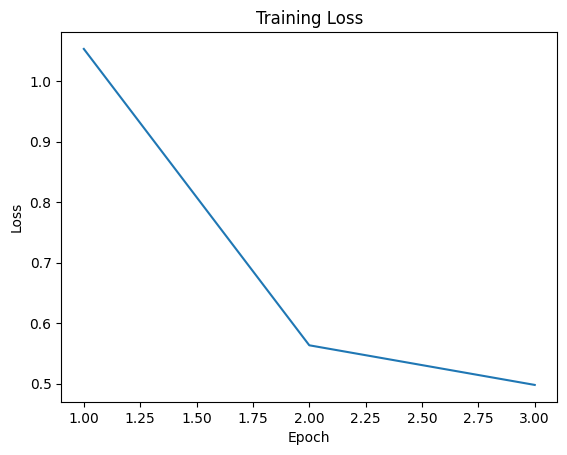

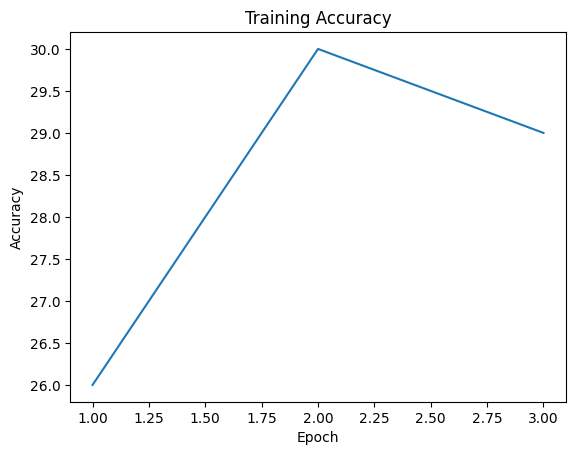

Epoch [1/4], Step [100/938], Loss: 1.8033, Accuracy: 64.06%
Epoch [1/4], Step [200/938], Loss: 1.3029, Accuracy: 68.75%
Epoch [1/4], Step [300/938], Loss: 0.9246, Accuracy: 75.00%
Epoch [1/4], Step [400/938], Loss: 0.8619, Accuracy: 78.12%
Epoch [1/4], Step [500/938], Loss: 0.6440, Accuracy: 76.56%
Epoch [1/4], Step [600/938], Loss: 0.5089, Accuracy: 85.94%
Epoch [1/4], Step [700/938], Loss: 0.7018, Accuracy: 70.31%
Epoch [1/4], Step [800/938], Loss: 0.6031, Accuracy: 78.12%
Epoch [1/4], Step [900/938], Loss: 0.6118, Accuracy: 75.00%
Validation Loss: 0.6244
Epoch [2/4], Step [100/938], Loss: 0.7018, Accuracy: 78.12%
Epoch [2/4], Step [200/938], Loss: 0.6695, Accuracy: 75.00%
Epoch [2/4], Step [300/938], Loss: 0.6308, Accuracy: 73.44%
Epoch [2/4], Step [400/938], Loss: 0.4189, Accuracy: 84.38%
Epoch [2/4], Step [500/938], Loss: 0.4152, Accuracy: 82.81%
Epoch [2/4], Step [600/938], Loss: 0.5537, Accuracy: 79.69%
Epoch [2/4], Step [700/938], Loss: 0.7732, Accuracy: 70.31%
Epoch [2/4], Ste

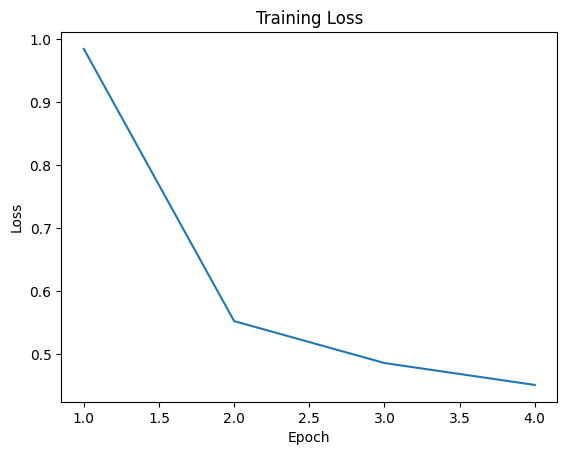

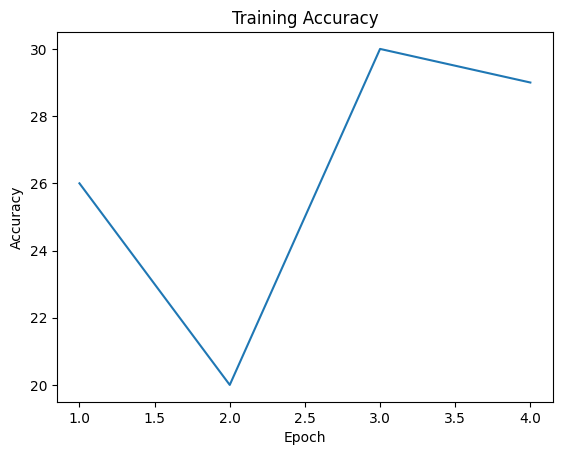

Epoch [1/5], Step [100/938], Loss: 1.7876, Accuracy: 53.12%
Epoch [1/5], Step [200/938], Loss: 1.2317, Accuracy: 68.75%
Epoch [1/5], Step [300/938], Loss: 0.9710, Accuracy: 75.00%
Epoch [1/5], Step [400/938], Loss: 0.8319, Accuracy: 73.44%
Epoch [1/5], Step [500/938], Loss: 0.7414, Accuracy: 71.88%
Epoch [1/5], Step [600/938], Loss: 0.8951, Accuracy: 65.62%
Epoch [1/5], Step [700/938], Loss: 0.6645, Accuracy: 79.69%
Epoch [1/5], Step [800/938], Loss: 0.4426, Accuracy: 85.94%
Epoch [1/5], Step [900/938], Loss: 0.6674, Accuracy: 71.88%
Validation Loss: 0.6406
Epoch [2/5], Step [100/938], Loss: 0.5887, Accuracy: 84.38%
Epoch [2/5], Step [200/938], Loss: 0.7531, Accuracy: 70.31%
Epoch [2/5], Step [300/938], Loss: 0.5621, Accuracy: 78.12%
Epoch [2/5], Step [400/938], Loss: 0.5279, Accuracy: 81.25%
Epoch [2/5], Step [500/938], Loss: 0.3922, Accuracy: 84.38%
Epoch [2/5], Step [600/938], Loss: 0.5814, Accuracy: 76.56%
Epoch [2/5], Step [700/938], Loss: 0.5690, Accuracy: 81.25%
Epoch [2/5], Ste

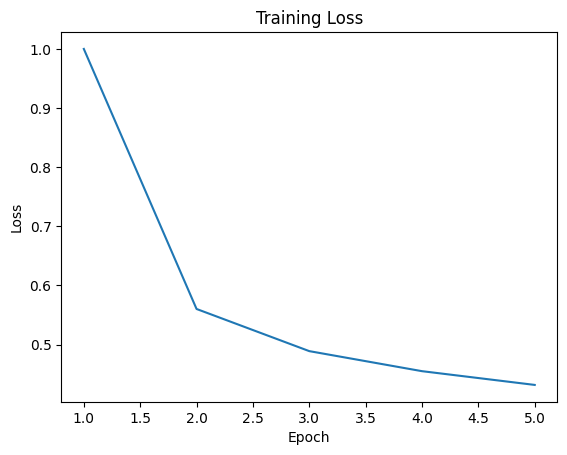

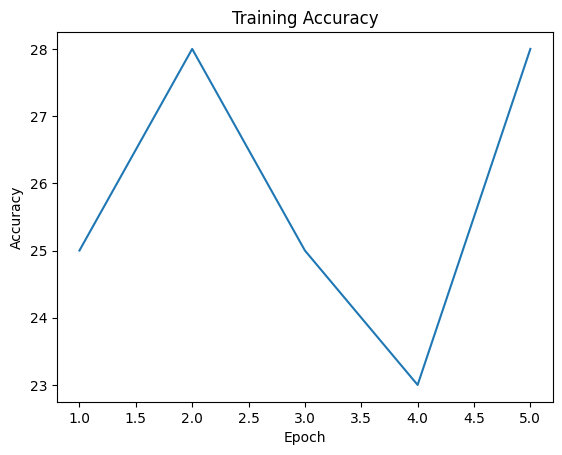

Epoch [1/6], Step [100/938], Loss: 1.9610, Accuracy: 43.75%
Epoch [1/6], Step [200/938], Loss: 1.2195, Accuracy: 70.31%
Epoch [1/6], Step [300/938], Loss: 0.9376, Accuracy: 76.56%
Epoch [1/6], Step [400/938], Loss: 0.8778, Accuracy: 75.00%
Epoch [1/6], Step [500/938], Loss: 0.8195, Accuracy: 71.88%
Epoch [1/6], Step [600/938], Loss: 0.6830, Accuracy: 71.88%
Epoch [1/6], Step [700/938], Loss: 0.7739, Accuracy: 70.31%
Epoch [1/6], Step [800/938], Loss: 0.5905, Accuracy: 84.38%
Epoch [1/6], Step [900/938], Loss: 0.5554, Accuracy: 78.12%
Validation Loss: 0.6334
Epoch [2/6], Step [100/938], Loss: 0.5768, Accuracy: 78.12%
Epoch [2/6], Step [200/938], Loss: 0.5592, Accuracy: 78.12%
Epoch [2/6], Step [300/938], Loss: 0.7201, Accuracy: 76.56%
Epoch [2/6], Step [400/938], Loss: 0.7082, Accuracy: 70.31%
Epoch [2/6], Step [500/938], Loss: 0.6561, Accuracy: 78.12%
Epoch [2/6], Step [600/938], Loss: 0.6299, Accuracy: 73.44%
Epoch [2/6], Step [700/938], Loss: 0.3136, Accuracy: 89.06%
Epoch [2/6], Ste

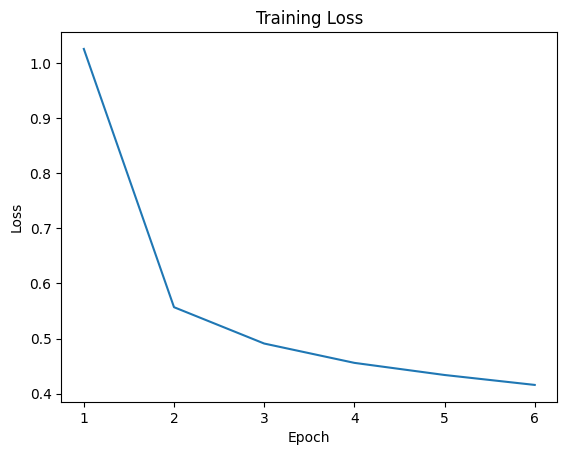

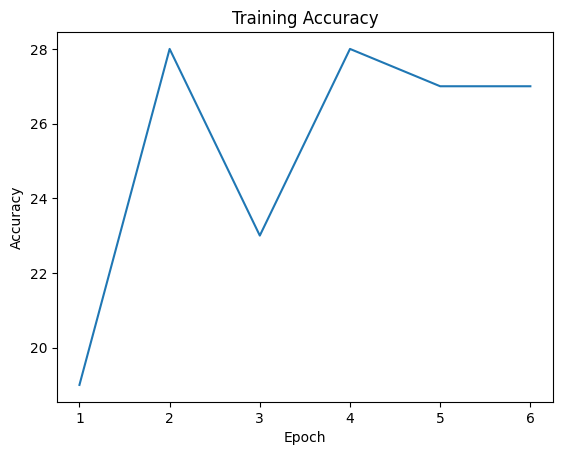

Epoch [1/7], Step [100/938], Loss: 1.9562, Accuracy: 32.81%
Epoch [1/7], Step [200/938], Loss: 1.5117, Accuracy: 43.75%
Epoch [1/7], Step [300/938], Loss: 0.9275, Accuracy: 75.00%
Epoch [1/7], Step [400/938], Loss: 0.9124, Accuracy: 65.62%
Epoch [1/7], Step [500/938], Loss: 0.7684, Accuracy: 70.31%
Epoch [1/7], Step [600/938], Loss: 0.6762, Accuracy: 73.44%
Epoch [1/7], Step [700/938], Loss: 0.7846, Accuracy: 68.75%
Epoch [1/7], Step [800/938], Loss: 0.8119, Accuracy: 73.44%
Epoch [1/7], Step [900/938], Loss: 0.7071, Accuracy: 71.88%
Validation Loss: 0.6499
Epoch [2/7], Step [100/938], Loss: 0.5181, Accuracy: 82.81%
Epoch [2/7], Step [200/938], Loss: 0.5260, Accuracy: 75.00%
Epoch [2/7], Step [300/938], Loss: 0.4714, Accuracy: 85.94%
Epoch [2/7], Step [400/938], Loss: 0.6447, Accuracy: 78.12%
Epoch [2/7], Step [500/938], Loss: 0.6349, Accuracy: 84.38%
Epoch [2/7], Step [600/938], Loss: 0.6785, Accuracy: 75.00%
Epoch [2/7], Step [700/938], Loss: 0.4846, Accuracy: 81.25%
Epoch [2/7], Ste

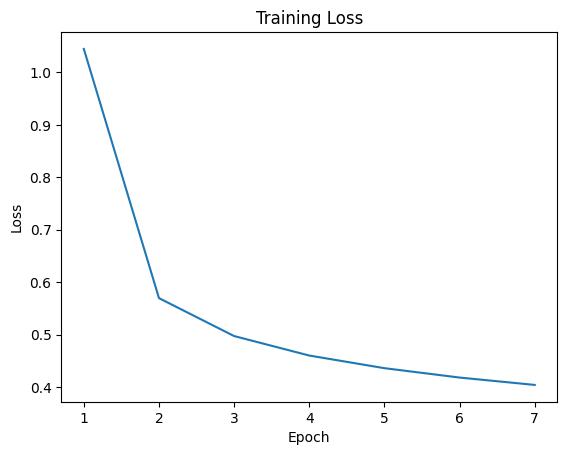

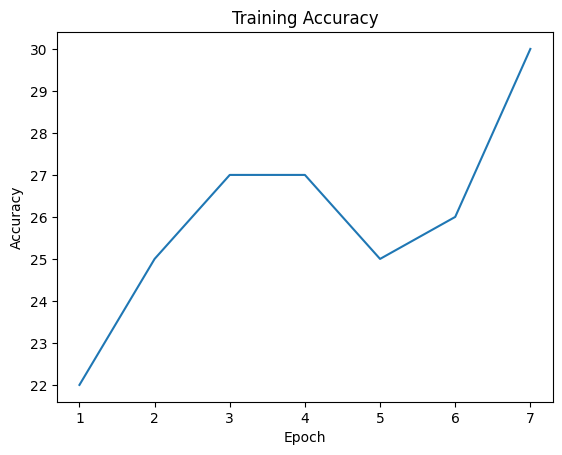

Epoch [1/8], Step [100/938], Loss: 1.8282, Accuracy: 56.25%
Epoch [1/8], Step [200/938], Loss: 1.4357, Accuracy: 59.38%
Epoch [1/8], Step [300/938], Loss: 1.0294, Accuracy: 62.50%
Epoch [1/8], Step [400/938], Loss: 0.8162, Accuracy: 73.44%
Epoch [1/8], Step [500/938], Loss: 0.6283, Accuracy: 78.12%
Epoch [1/8], Step [600/938], Loss: 0.6594, Accuracy: 76.56%
Epoch [1/8], Step [700/938], Loss: 0.5737, Accuracy: 81.25%
Epoch [1/8], Step [800/938], Loss: 0.7088, Accuracy: 68.75%
Epoch [1/8], Step [900/938], Loss: 0.7698, Accuracy: 79.69%
Validation Loss: 0.6246
Epoch [2/8], Step [100/938], Loss: 0.4780, Accuracy: 82.81%
Epoch [2/8], Step [200/938], Loss: 0.5901, Accuracy: 79.69%
Epoch [2/8], Step [300/938], Loss: 0.6477, Accuracy: 71.88%
Epoch [2/8], Step [400/938], Loss: 0.6384, Accuracy: 70.31%
Epoch [2/8], Step [500/938], Loss: 0.5540, Accuracy: 81.25%
Epoch [2/8], Step [600/938], Loss: 0.5740, Accuracy: 75.00%
Epoch [2/8], Step [700/938], Loss: 0.5897, Accuracy: 78.12%
Epoch [2/8], Ste

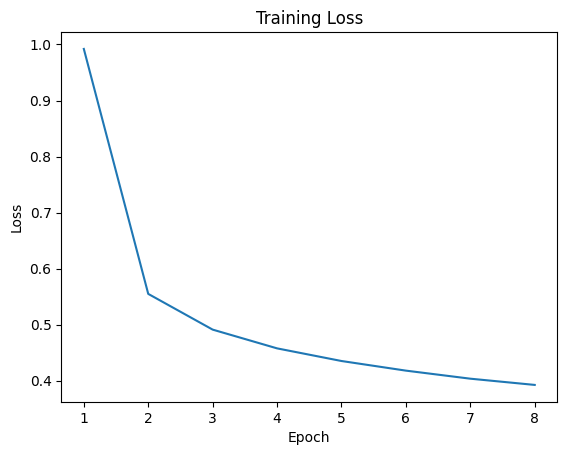

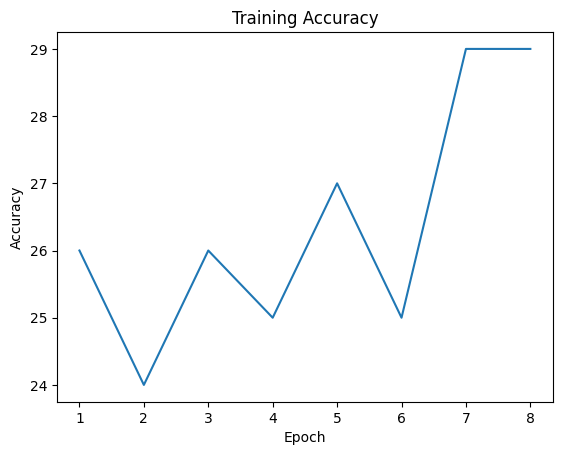

Epoch [1/9], Step [100/938], Loss: 2.0055, Accuracy: 29.69%
Epoch [1/9], Step [200/938], Loss: 1.3219, Accuracy: 64.06%
Epoch [1/9], Step [300/938], Loss: 1.1573, Accuracy: 59.38%
Epoch [1/9], Step [400/938], Loss: 0.8672, Accuracy: 73.44%
Epoch [1/9], Step [500/938], Loss: 0.7166, Accuracy: 79.69%
Epoch [1/9], Step [600/938], Loss: 0.7883, Accuracy: 70.31%
Epoch [1/9], Step [700/938], Loss: 0.5384, Accuracy: 79.69%
Epoch [1/9], Step [800/938], Loss: 0.8155, Accuracy: 68.75%
Epoch [1/9], Step [900/938], Loss: 0.6031, Accuracy: 81.25%
Validation Loss: 0.6377
Epoch [2/9], Step [100/938], Loss: 0.5105, Accuracy: 76.56%
Epoch [2/9], Step [200/938], Loss: 0.6909, Accuracy: 73.44%
Epoch [2/9], Step [300/938], Loss: 0.4911, Accuracy: 82.81%
Epoch [2/9], Step [400/938], Loss: 0.4738, Accuracy: 81.25%
Epoch [2/9], Step [500/938], Loss: 0.5480, Accuracy: 81.25%
Epoch [2/9], Step [600/938], Loss: 0.6698, Accuracy: 68.75%
Epoch [2/9], Step [700/938], Loss: 0.5342, Accuracy: 81.25%
Epoch [2/9], Ste

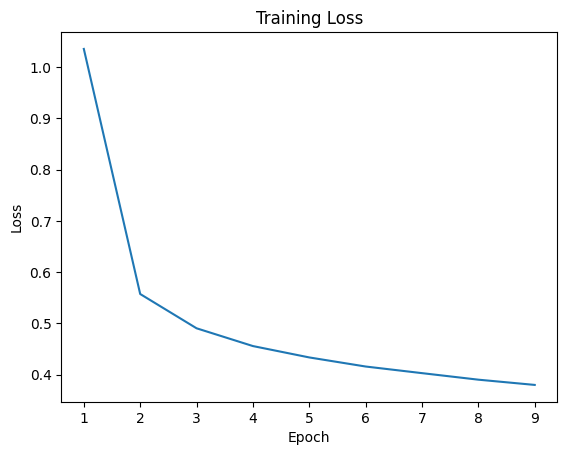

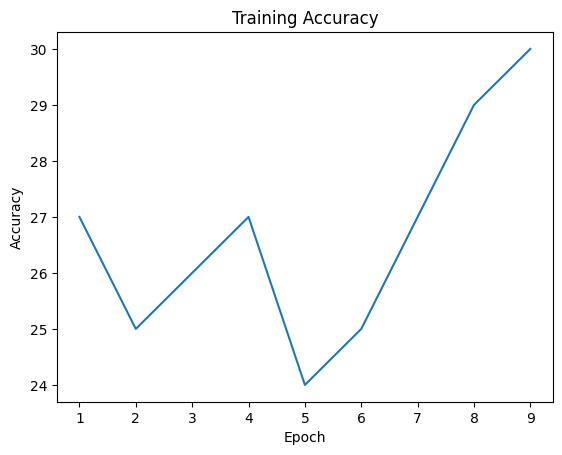

Epoch [1/10], Step [100/938], Loss: 1.8883, Accuracy: 53.12%
Epoch [1/10], Step [200/938], Loss: 1.2927, Accuracy: 60.94%
Epoch [1/10], Step [300/938], Loss: 1.0253, Accuracy: 73.44%
Epoch [1/10], Step [400/938], Loss: 0.8747, Accuracy: 75.00%
Epoch [1/10], Step [500/938], Loss: 0.7564, Accuracy: 70.31%
Epoch [1/10], Step [600/938], Loss: 0.7785, Accuracy: 70.31%
Epoch [1/10], Step [700/938], Loss: 0.7014, Accuracy: 75.00%
Epoch [1/10], Step [800/938], Loss: 0.5449, Accuracy: 81.25%
Epoch [1/10], Step [900/938], Loss: 0.5679, Accuracy: 73.44%
Validation Loss: 0.6614
Epoch [2/10], Step [100/938], Loss: 0.4942, Accuracy: 78.12%
Epoch [2/10], Step [200/938], Loss: 0.8442, Accuracy: 70.31%
Epoch [2/10], Step [300/938], Loss: 0.4298, Accuracy: 87.50%
Epoch [2/10], Step [400/938], Loss: 0.5005, Accuracy: 82.81%
Epoch [2/10], Step [500/938], Loss: 0.6804, Accuracy: 71.88%
Epoch [2/10], Step [600/938], Loss: 0.5363, Accuracy: 82.81%
Epoch [2/10], Step [700/938], Loss: 0.6262, Accuracy: 76.56%


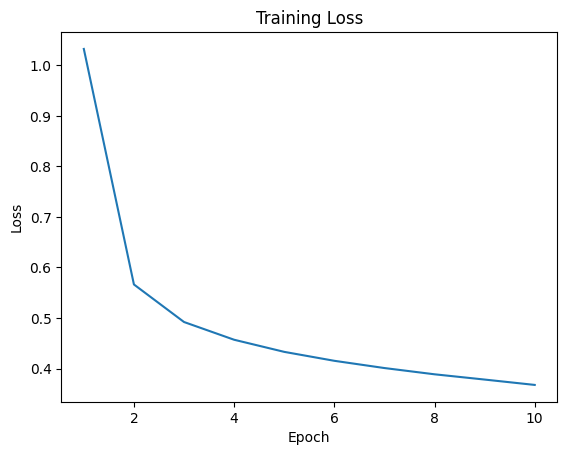

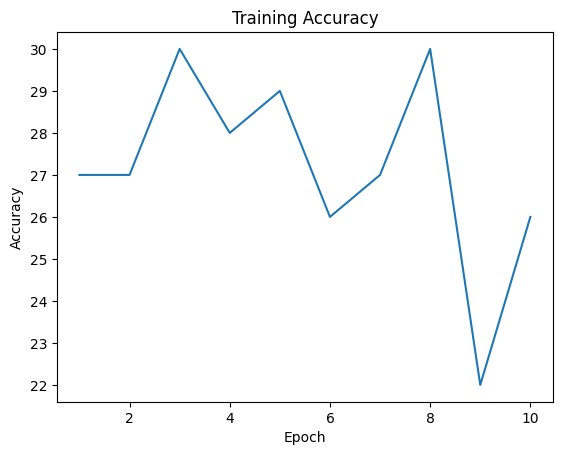

Epoch [1/11], Step [100/938], Loss: 1.8822, Accuracy: 57.81%
Epoch [1/11], Step [200/938], Loss: 1.2306, Accuracy: 60.94%
Epoch [1/11], Step [300/938], Loss: 0.9719, Accuracy: 64.06%
Epoch [1/11], Step [400/938], Loss: 1.0034, Accuracy: 67.19%
Epoch [1/11], Step [500/938], Loss: 0.7684, Accuracy: 78.12%
Epoch [1/11], Step [600/938], Loss: 0.6469, Accuracy: 78.12%
Epoch [1/11], Step [700/938], Loss: 0.6713, Accuracy: 71.88%
Epoch [1/11], Step [800/938], Loss: 0.6452, Accuracy: 78.12%
Epoch [1/11], Step [900/938], Loss: 0.6420, Accuracy: 73.44%
Validation Loss: 0.6260
Epoch [2/11], Step [100/938], Loss: 0.6240, Accuracy: 76.56%
Epoch [2/11], Step [200/938], Loss: 0.5998, Accuracy: 78.12%
Epoch [2/11], Step [300/938], Loss: 0.5833, Accuracy: 75.00%
Epoch [2/11], Step [400/938], Loss: 0.5090, Accuracy: 82.81%
Epoch [2/11], Step [500/938], Loss: 0.4372, Accuracy: 87.50%
Epoch [2/11], Step [600/938], Loss: 0.5002, Accuracy: 85.94%
Epoch [2/11], Step [700/938], Loss: 0.4211, Accuracy: 84.38%


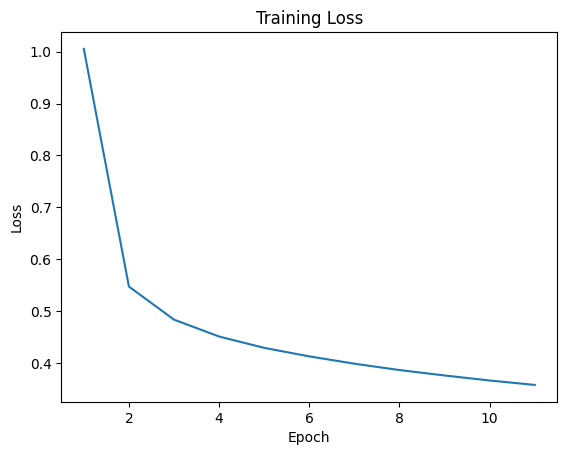

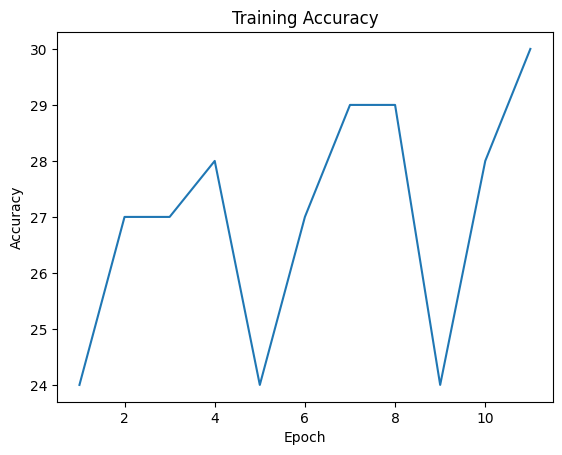

Epoch [1/12], Step [100/938], Loss: 1.9559, Accuracy: 28.12%
Epoch [1/12], Step [200/938], Loss: 1.4220, Accuracy: 60.94%
Epoch [1/12], Step [300/938], Loss: 0.8898, Accuracy: 71.88%
Epoch [1/12], Step [400/938], Loss: 0.7650, Accuracy: 78.12%
Epoch [1/12], Step [500/938], Loss: 0.8450, Accuracy: 70.31%
Epoch [1/12], Step [600/938], Loss: 0.6269, Accuracy: 78.12%
Epoch [1/12], Step [700/938], Loss: 0.7389, Accuracy: 73.44%
Epoch [1/12], Step [800/938], Loss: 0.7003, Accuracy: 81.25%
Epoch [1/12], Step [900/938], Loss: 0.7209, Accuracy: 67.19%
Validation Loss: 0.6370
Epoch [2/12], Step [100/938], Loss: 0.4206, Accuracy: 85.94%
Epoch [2/12], Step [200/938], Loss: 0.7949, Accuracy: 75.00%
Epoch [2/12], Step [300/938], Loss: 0.6505, Accuracy: 78.12%
Epoch [2/12], Step [400/938], Loss: 0.5420, Accuracy: 75.00%
Epoch [2/12], Step [500/938], Loss: 0.4839, Accuracy: 79.69%
Epoch [2/12], Step [600/938], Loss: 0.5538, Accuracy: 81.25%
Epoch [2/12], Step [700/938], Loss: 0.4526, Accuracy: 84.38%


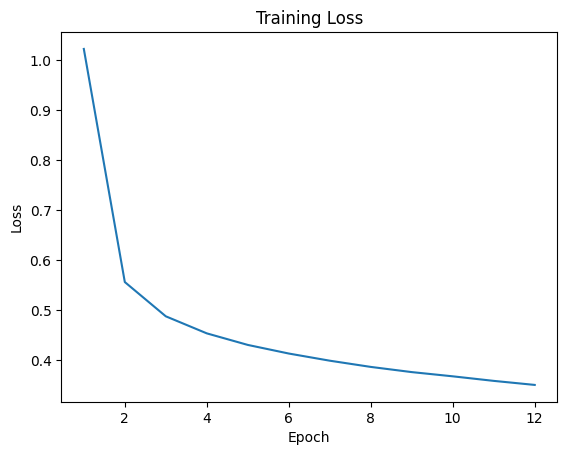

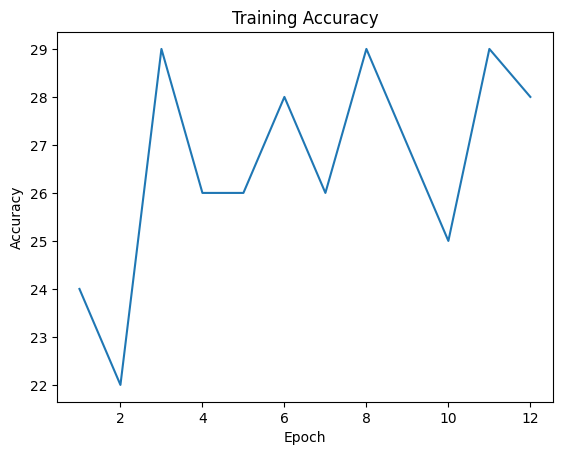

Epoch [1/13], Step [100/938], Loss: 1.9237, Accuracy: 48.44%
Epoch [1/13], Step [200/938], Loss: 1.3346, Accuracy: 59.38%
Epoch [1/13], Step [300/938], Loss: 1.0269, Accuracy: 70.31%
Epoch [1/13], Step [400/938], Loss: 1.0812, Accuracy: 60.94%
Epoch [1/13], Step [500/938], Loss: 0.6585, Accuracy: 79.69%
Epoch [1/13], Step [600/938], Loss: 0.7847, Accuracy: 70.31%
Epoch [1/13], Step [700/938], Loss: 0.6875, Accuracy: 70.31%
Epoch [1/13], Step [800/938], Loss: 0.8482, Accuracy: 71.88%
Epoch [1/13], Step [900/938], Loss: 0.6149, Accuracy: 75.00%
Validation Loss: 0.6340
Epoch [2/13], Step [100/938], Loss: 0.4934, Accuracy: 81.25%
Epoch [2/13], Step [200/938], Loss: 0.5950, Accuracy: 75.00%
Epoch [2/13], Step [300/938], Loss: 0.4090, Accuracy: 84.38%
Epoch [2/13], Step [400/938], Loss: 0.4032, Accuracy: 85.94%
Epoch [2/13], Step [500/938], Loss: 0.6866, Accuracy: 79.69%
Epoch [2/13], Step [600/938], Loss: 0.5420, Accuracy: 89.06%
Epoch [2/13], Step [700/938], Loss: 0.4614, Accuracy: 82.81%


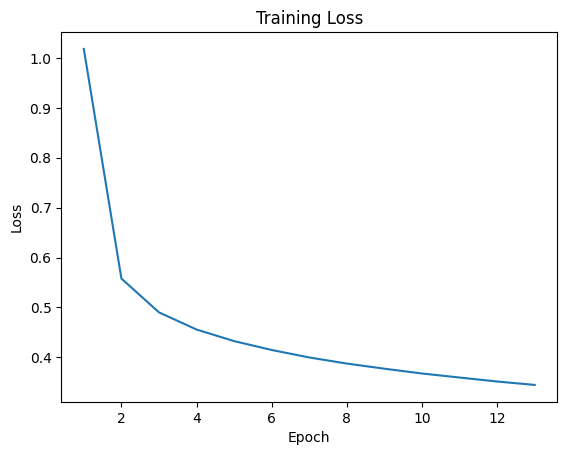

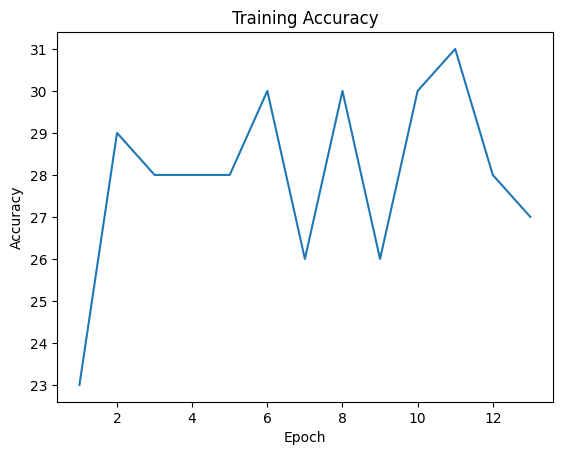

Epoch [1/14], Step [100/938], Loss: 1.8508, Accuracy: 51.56%
Epoch [1/14], Step [200/938], Loss: 1.1872, Accuracy: 68.75%
Epoch [1/14], Step [300/938], Loss: 0.8705, Accuracy: 73.44%
Epoch [1/14], Step [400/938], Loss: 0.7911, Accuracy: 81.25%
Epoch [1/14], Step [500/938], Loss: 0.8992, Accuracy: 75.00%
Epoch [1/14], Step [600/938], Loss: 0.5422, Accuracy: 78.12%
Epoch [1/14], Step [700/938], Loss: 0.7529, Accuracy: 78.12%
Epoch [1/14], Step [800/938], Loss: 0.5706, Accuracy: 79.69%
Epoch [1/14], Step [900/938], Loss: 0.6722, Accuracy: 70.31%
Validation Loss: 0.6367
Epoch [2/14], Step [100/938], Loss: 0.5829, Accuracy: 79.69%
Epoch [2/14], Step [200/938], Loss: 0.4695, Accuracy: 81.25%
Epoch [2/14], Step [300/938], Loss: 0.6406, Accuracy: 79.69%
Epoch [2/14], Step [400/938], Loss: 0.5093, Accuracy: 82.81%
Epoch [2/14], Step [500/938], Loss: 0.4823, Accuracy: 87.50%
Epoch [2/14], Step [600/938], Loss: 0.5432, Accuracy: 78.12%
Epoch [2/14], Step [700/938], Loss: 0.5166, Accuracy: 84.38%


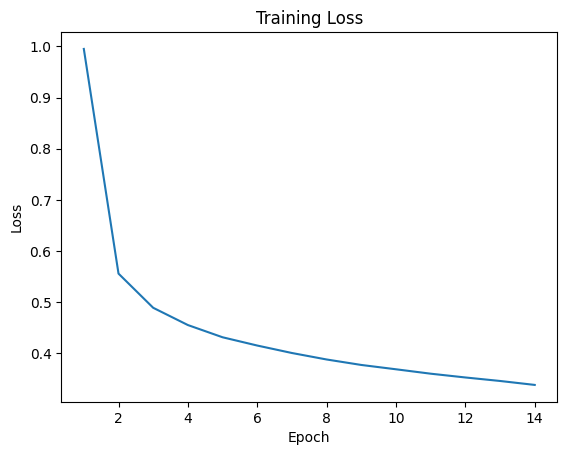

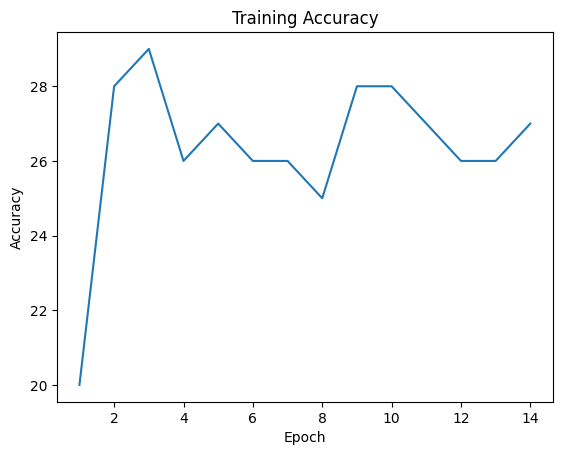

Epoch [1/15], Step [100/938], Loss: 1.9251, Accuracy: 37.50%
Epoch [1/15], Step [200/938], Loss: 1.3405, Accuracy: 65.62%
Epoch [1/15], Step [300/938], Loss: 0.9211, Accuracy: 78.12%
Epoch [1/15], Step [400/938], Loss: 0.8482, Accuracy: 70.31%
Epoch [1/15], Step [500/938], Loss: 0.7230, Accuracy: 78.12%
Epoch [1/15], Step [600/938], Loss: 0.5803, Accuracy: 81.25%
Epoch [1/15], Step [700/938], Loss: 0.7003, Accuracy: 76.56%
Epoch [1/15], Step [800/938], Loss: 0.6595, Accuracy: 81.25%
Epoch [1/15], Step [900/938], Loss: 0.6369, Accuracy: 75.00%
Validation Loss: 0.6372
Epoch [2/15], Step [100/938], Loss: 0.4572, Accuracy: 85.94%
Epoch [2/15], Step [200/938], Loss: 0.6068, Accuracy: 76.56%
Epoch [2/15], Step [300/938], Loss: 0.4985, Accuracy: 89.06%
Epoch [2/15], Step [400/938], Loss: 0.4509, Accuracy: 84.38%
Epoch [2/15], Step [500/938], Loss: 0.4467, Accuracy: 84.38%
Epoch [2/15], Step [600/938], Loss: 0.5931, Accuracy: 78.12%
Epoch [2/15], Step [700/938], Loss: 0.4446, Accuracy: 87.50%


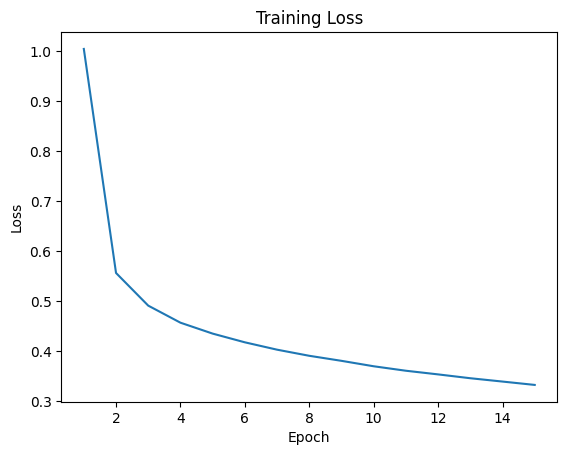

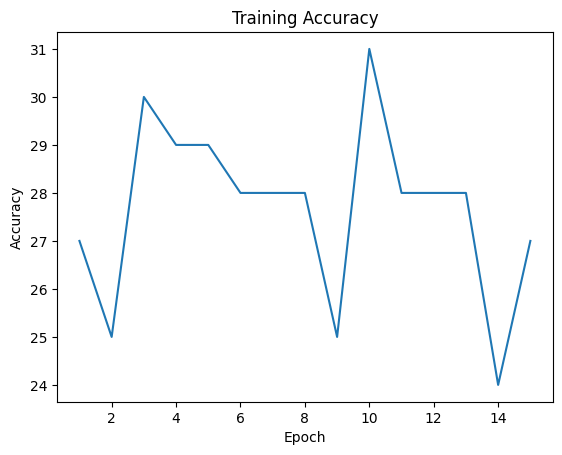

Epoch [1/16], Step [100/938], Loss: 1.8102, Accuracy: 53.12%
Epoch [1/16], Step [200/938], Loss: 1.2703, Accuracy: 62.50%
Epoch [1/16], Step [300/938], Loss: 1.0980, Accuracy: 67.19%
Epoch [1/16], Step [400/938], Loss: 0.9700, Accuracy: 67.19%
Epoch [1/16], Step [500/938], Loss: 0.7696, Accuracy: 71.88%
Epoch [1/16], Step [600/938], Loss: 0.8288, Accuracy: 67.19%
Epoch [1/16], Step [700/938], Loss: 0.6556, Accuracy: 78.12%
Epoch [1/16], Step [800/938], Loss: 0.5911, Accuracy: 84.38%
Epoch [1/16], Step [900/938], Loss: 0.6720, Accuracy: 76.56%
Validation Loss: 0.6376
Epoch [2/16], Step [100/938], Loss: 0.6445, Accuracy: 79.69%
Epoch [2/16], Step [200/938], Loss: 0.5056, Accuracy: 76.56%
Epoch [2/16], Step [300/938], Loss: 0.6003, Accuracy: 73.44%
Epoch [2/16], Step [400/938], Loss: 0.5180, Accuracy: 78.12%
Epoch [2/16], Step [500/938], Loss: 0.4361, Accuracy: 85.94%
Epoch [2/16], Step [600/938], Loss: 0.5403, Accuracy: 75.00%
Epoch [2/16], Step [700/938], Loss: 0.4541, Accuracy: 85.94%


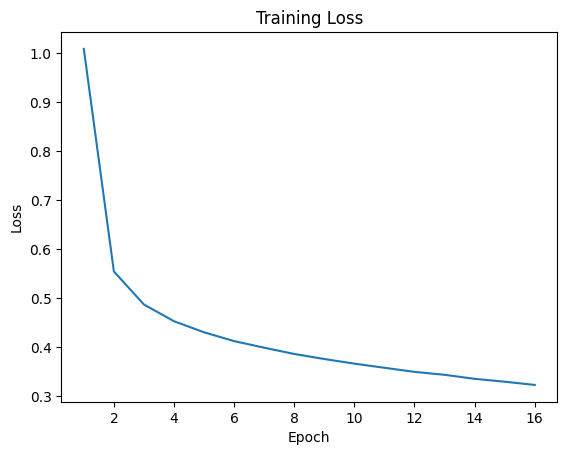

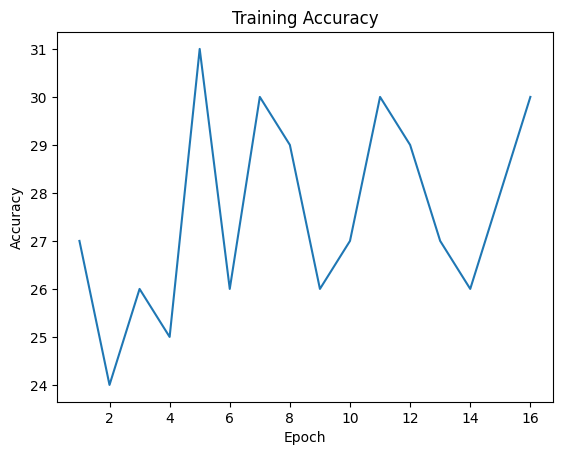

Epoch [1/17], Step [100/938], Loss: 1.7193, Accuracy: 57.81%
Epoch [1/17], Step [200/938], Loss: 1.1590, Accuracy: 62.50%
Epoch [1/17], Step [300/938], Loss: 1.0696, Accuracy: 67.19%
Epoch [1/17], Step [400/938], Loss: 0.7702, Accuracy: 73.44%
Epoch [1/17], Step [500/938], Loss: 0.7554, Accuracy: 73.44%
Epoch [1/17], Step [600/938], Loss: 0.6328, Accuracy: 82.81%
Epoch [1/17], Step [700/938], Loss: 0.7027, Accuracy: 75.00%
Epoch [1/17], Step [800/938], Loss: 0.5555, Accuracy: 84.38%
Epoch [1/17], Step [900/938], Loss: 0.7436, Accuracy: 68.75%
Validation Loss: 0.6660
Epoch [2/17], Step [100/938], Loss: 0.5677, Accuracy: 78.12%
Epoch [2/17], Step [200/938], Loss: 0.5550, Accuracy: 78.12%
Epoch [2/17], Step [300/938], Loss: 0.5448, Accuracy: 78.12%
Epoch [2/17], Step [400/938], Loss: 0.4760, Accuracy: 82.81%
Epoch [2/17], Step [500/938], Loss: 0.7075, Accuracy: 65.62%
Epoch [2/17], Step [600/938], Loss: 0.5418, Accuracy: 78.12%
Epoch [2/17], Step [700/938], Loss: 0.5890, Accuracy: 81.25%


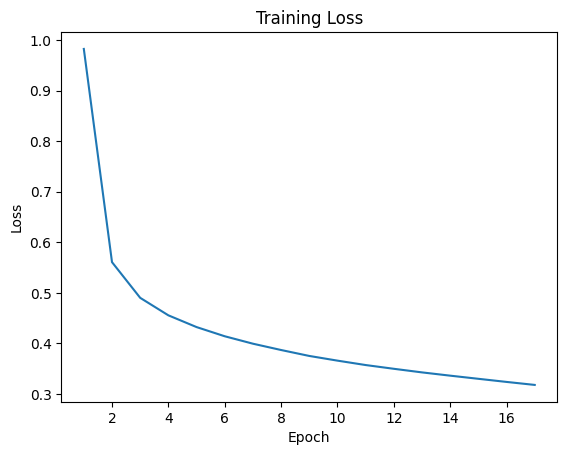

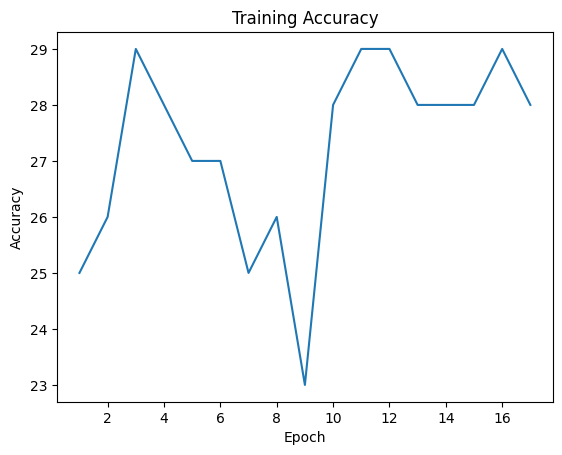

Epoch [1/18], Step [100/938], Loss: 1.8712, Accuracy: 51.56%
Epoch [1/18], Step [200/938], Loss: 1.3874, Accuracy: 60.94%
Epoch [1/18], Step [300/938], Loss: 0.9780, Accuracy: 76.56%
Epoch [1/18], Step [400/938], Loss: 0.9352, Accuracy: 67.19%
Epoch [1/18], Step [500/938], Loss: 0.6573, Accuracy: 73.44%
Epoch [1/18], Step [600/938], Loss: 0.5986, Accuracy: 81.25%
Epoch [1/18], Step [700/938], Loss: 0.8636, Accuracy: 62.50%
Epoch [1/18], Step [800/938], Loss: 0.7343, Accuracy: 75.00%
Epoch [1/18], Step [900/938], Loss: 0.6369, Accuracy: 76.56%
Validation Loss: 0.6423
Epoch [2/18], Step [100/938], Loss: 0.5833, Accuracy: 84.38%
Epoch [2/18], Step [200/938], Loss: 0.5400, Accuracy: 84.38%
Epoch [2/18], Step [300/938], Loss: 0.7919, Accuracy: 78.12%
Epoch [2/18], Step [400/938], Loss: 0.6610, Accuracy: 76.56%
Epoch [2/18], Step [500/938], Loss: 0.4012, Accuracy: 84.38%
Epoch [2/18], Step [600/938], Loss: 0.8332, Accuracy: 71.88%
Epoch [2/18], Step [700/938], Loss: 0.6392, Accuracy: 79.69%


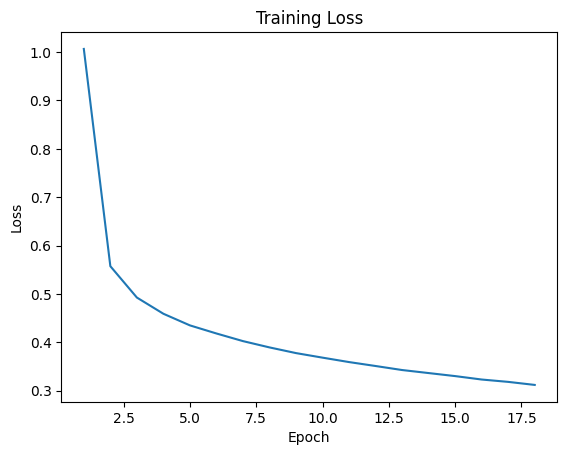

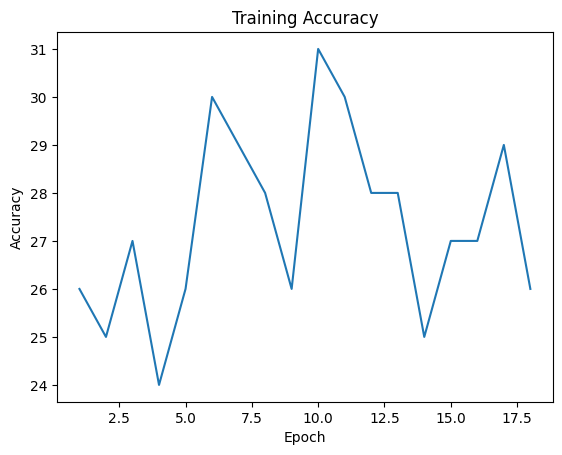

Epoch [1/19], Step [100/938], Loss: 1.9677, Accuracy: 54.69%
Epoch [1/19], Step [200/938], Loss: 1.3800, Accuracy: 65.62%
Epoch [1/19], Step [300/938], Loss: 1.0993, Accuracy: 71.88%
Epoch [1/19], Step [400/938], Loss: 1.0237, Accuracy: 65.62%
Epoch [1/19], Step [500/938], Loss: 0.7992, Accuracy: 68.75%
Epoch [1/19], Step [600/938], Loss: 0.7764, Accuracy: 73.44%
Epoch [1/19], Step [700/938], Loss: 0.6959, Accuracy: 70.31%
Epoch [1/19], Step [800/938], Loss: 0.7393, Accuracy: 67.19%
Epoch [1/19], Step [900/938], Loss: 0.7539, Accuracy: 67.19%
Validation Loss: 0.6300
Epoch [2/19], Step [100/938], Loss: 0.6003, Accuracy: 82.81%
Epoch [2/19], Step [200/938], Loss: 0.6263, Accuracy: 75.00%
Epoch [2/19], Step [300/938], Loss: 0.5680, Accuracy: 76.56%
Epoch [2/19], Step [400/938], Loss: 0.5998, Accuracy: 78.12%
Epoch [2/19], Step [500/938], Loss: 0.4427, Accuracy: 78.12%
Epoch [2/19], Step [600/938], Loss: 0.4225, Accuracy: 84.38%
Epoch [2/19], Step [700/938], Loss: 0.5949, Accuracy: 76.56%


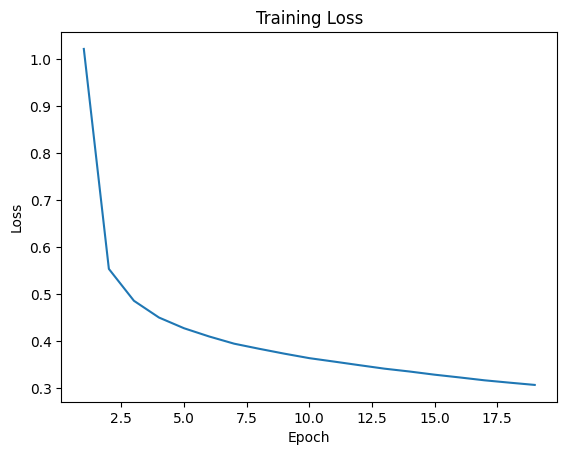

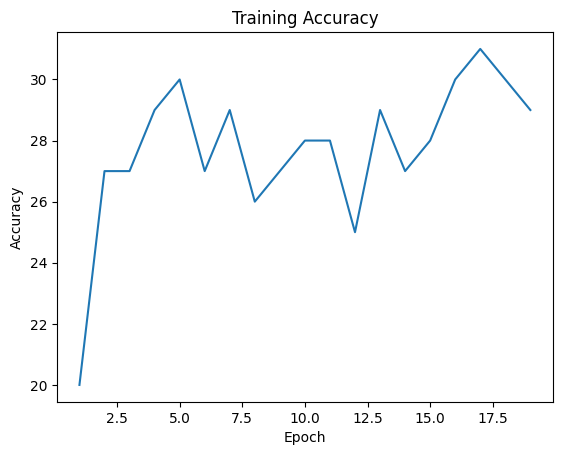

Epoch [1/20], Step [100/938], Loss: 2.0468, Accuracy: 39.06%
Epoch [1/20], Step [200/938], Loss: 1.2741, Accuracy: 70.31%
Epoch [1/20], Step [300/938], Loss: 0.9892, Accuracy: 78.12%
Epoch [1/20], Step [400/938], Loss: 0.9311, Accuracy: 73.44%
Epoch [1/20], Step [500/938], Loss: 0.7838, Accuracy: 70.31%
Epoch [1/20], Step [600/938], Loss: 0.6688, Accuracy: 79.69%
Epoch [1/20], Step [700/938], Loss: 0.6846, Accuracy: 84.38%
Epoch [1/20], Step [800/938], Loss: 0.7340, Accuracy: 73.44%
Epoch [1/20], Step [900/938], Loss: 0.4947, Accuracy: 81.25%
Validation Loss: 0.6312
Epoch [2/20], Step [100/938], Loss: 0.5763, Accuracy: 75.00%
Epoch [2/20], Step [200/938], Loss: 0.5823, Accuracy: 76.56%
Epoch [2/20], Step [300/938], Loss: 0.5932, Accuracy: 75.00%
Epoch [2/20], Step [400/938], Loss: 0.4567, Accuracy: 84.38%
Epoch [2/20], Step [500/938], Loss: 0.6813, Accuracy: 73.44%
Epoch [2/20], Step [600/938], Loss: 0.4321, Accuracy: 85.94%
Epoch [2/20], Step [700/938], Loss: 0.5757, Accuracy: 76.56%


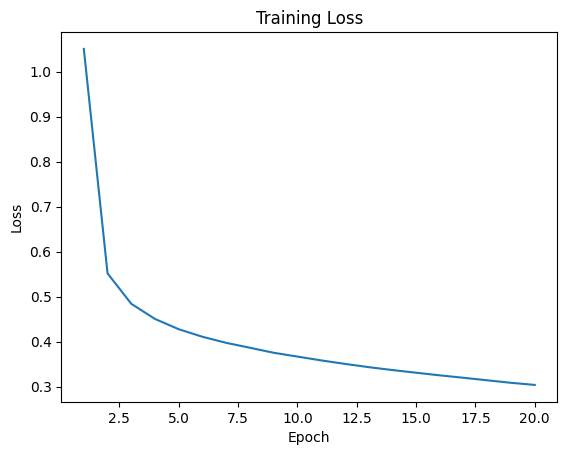

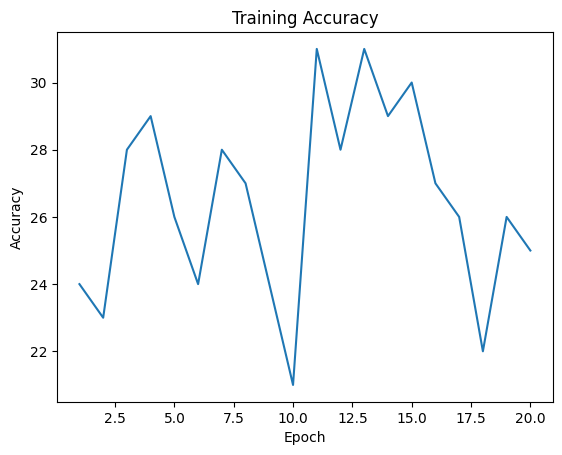

Epoch [1/21], Step [100/938], Loss: 1.8930, Accuracy: 42.19%
Epoch [1/21], Step [200/938], Loss: 1.4796, Accuracy: 51.56%
Epoch [1/21], Step [300/938], Loss: 1.2203, Accuracy: 59.38%
Epoch [1/21], Step [400/938], Loss: 0.9324, Accuracy: 71.88%
Epoch [1/21], Step [500/938], Loss: 0.8144, Accuracy: 73.44%
Epoch [1/21], Step [600/938], Loss: 0.6552, Accuracy: 79.69%
Epoch [1/21], Step [700/938], Loss: 0.5216, Accuracy: 85.94%
Epoch [1/21], Step [800/938], Loss: 0.7001, Accuracy: 73.44%
Epoch [1/21], Step [900/938], Loss: 0.4963, Accuracy: 84.38%
Validation Loss: 0.6507
Epoch [2/21], Step [100/938], Loss: 0.5203, Accuracy: 81.25%
Epoch [2/21], Step [200/938], Loss: 0.5894, Accuracy: 79.69%
Epoch [2/21], Step [300/938], Loss: 0.5955, Accuracy: 81.25%
Epoch [2/21], Step [400/938], Loss: 0.5070, Accuracy: 82.81%
Epoch [2/21], Step [500/938], Loss: 0.6264, Accuracy: 78.12%
Epoch [2/21], Step [600/938], Loss: 0.4771, Accuracy: 84.38%
Epoch [2/21], Step [700/938], Loss: 0.4725, Accuracy: 84.38%


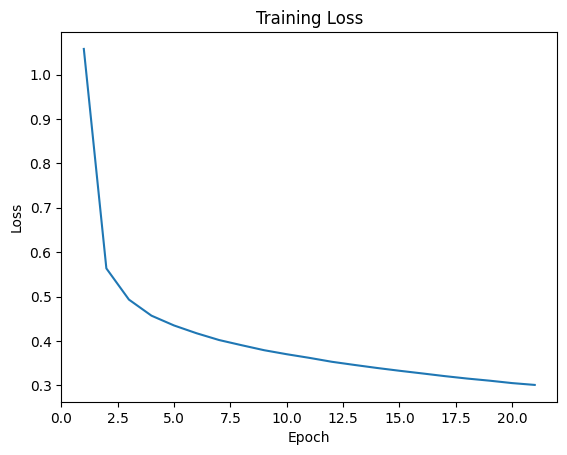

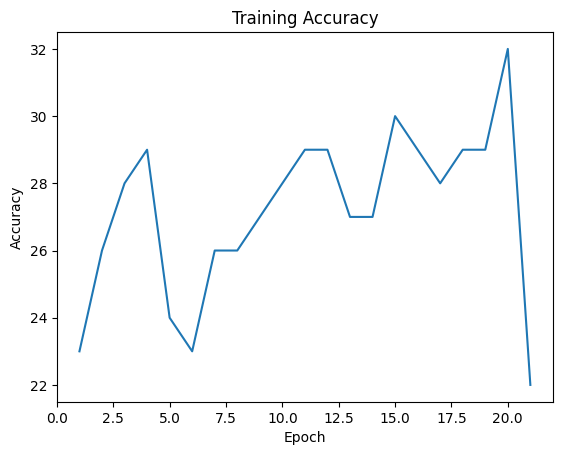

Epoch [1/22], Step [100/938], Loss: 1.9409, Accuracy: 45.31%
Epoch [1/22], Step [200/938], Loss: 1.4048, Accuracy: 57.81%
Epoch [1/22], Step [300/938], Loss: 1.0144, Accuracy: 71.88%
Epoch [1/22], Step [400/938], Loss: 0.8860, Accuracy: 76.56%
Epoch [1/22], Step [500/938], Loss: 0.6657, Accuracy: 82.81%
Epoch [1/22], Step [600/938], Loss: 0.7633, Accuracy: 71.88%
Epoch [1/22], Step [700/938], Loss: 0.7576, Accuracy: 73.44%
Epoch [1/22], Step [800/938], Loss: 0.5595, Accuracy: 78.12%
Epoch [1/22], Step [900/938], Loss: 0.6348, Accuracy: 76.56%
Validation Loss: 0.6415
Epoch [2/22], Step [100/938], Loss: 0.5038, Accuracy: 76.56%
Epoch [2/22], Step [200/938], Loss: 0.4820, Accuracy: 82.81%
Epoch [2/22], Step [300/938], Loss: 0.6151, Accuracy: 75.00%
Epoch [2/22], Step [400/938], Loss: 0.7202, Accuracy: 68.75%
Epoch [2/22], Step [500/938], Loss: 0.5570, Accuracy: 73.44%
Epoch [2/22], Step [600/938], Loss: 0.5350, Accuracy: 75.00%
Epoch [2/22], Step [700/938], Loss: 0.4939, Accuracy: 85.94%


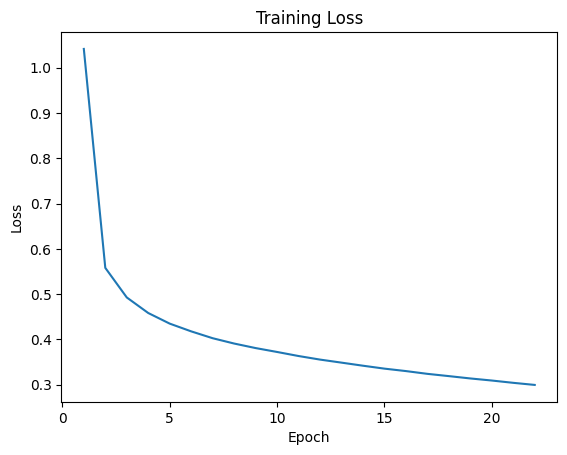

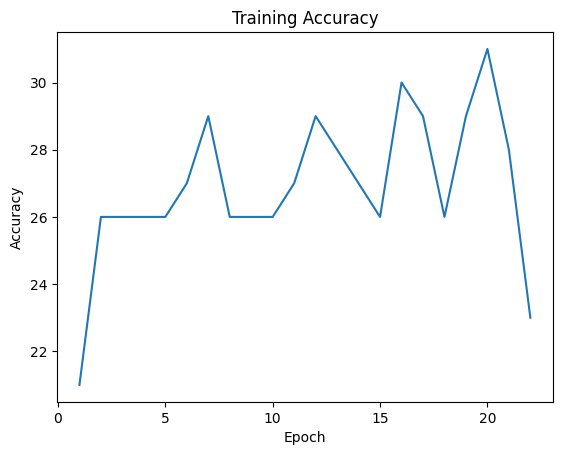

Epoch [1/23], Step [100/938], Loss: 1.7705, Accuracy: 50.00%
Epoch [1/23], Step [200/938], Loss: 1.1312, Accuracy: 68.75%
Epoch [1/23], Step [300/938], Loss: 0.8277, Accuracy: 75.00%
Epoch [1/23], Step [400/938], Loss: 0.7852, Accuracy: 73.44%
Epoch [1/23], Step [500/938], Loss: 0.8083, Accuracy: 67.19%
Epoch [1/23], Step [600/938], Loss: 0.6525, Accuracy: 73.44%
Epoch [1/23], Step [700/938], Loss: 0.7472, Accuracy: 65.62%
Epoch [1/23], Step [800/938], Loss: 0.7596, Accuracy: 71.88%
Epoch [1/23], Step [900/938], Loss: 0.6090, Accuracy: 73.44%
Validation Loss: 0.6470
Epoch [2/23], Step [100/938], Loss: 0.5375, Accuracy: 85.94%
Epoch [2/23], Step [200/938], Loss: 0.5477, Accuracy: 78.12%
Epoch [2/23], Step [300/938], Loss: 0.5524, Accuracy: 79.69%
Epoch [2/23], Step [400/938], Loss: 0.7565, Accuracy: 71.88%
Epoch [2/23], Step [500/938], Loss: 0.5805, Accuracy: 79.69%
Epoch [2/23], Step [600/938], Loss: 0.5661, Accuracy: 78.12%
Epoch [2/23], Step [700/938], Loss: 0.5001, Accuracy: 81.25%


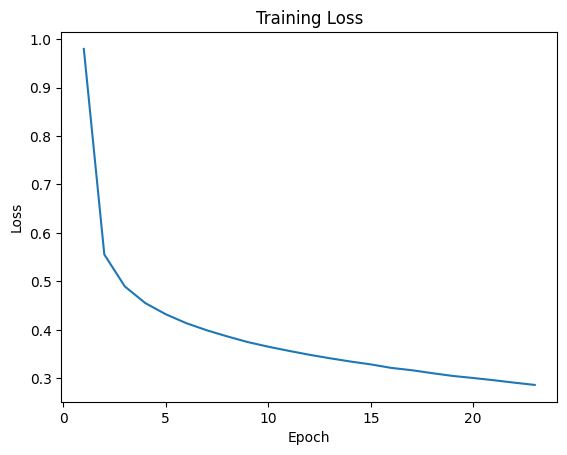

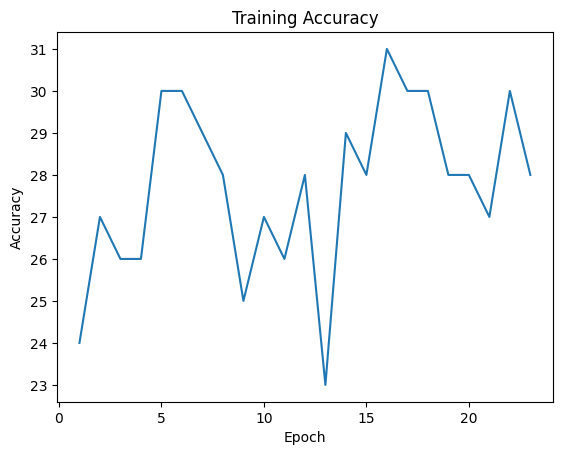

Epoch [1/24], Step [100/938], Loss: 1.9422, Accuracy: 35.94%
Epoch [1/24], Step [200/938], Loss: 1.3169, Accuracy: 54.69%
Epoch [1/24], Step [300/938], Loss: 1.0911, Accuracy: 67.19%
Epoch [1/24], Step [400/938], Loss: 0.9938, Accuracy: 62.50%
Epoch [1/24], Step [500/938], Loss: 0.9098, Accuracy: 68.75%
Epoch [1/24], Step [600/938], Loss: 0.8161, Accuracy: 67.19%
Epoch [1/24], Step [700/938], Loss: 0.6487, Accuracy: 70.31%
Epoch [1/24], Step [800/938], Loss: 0.4591, Accuracy: 82.81%
Epoch [1/24], Step [900/938], Loss: 0.6347, Accuracy: 79.69%
Validation Loss: 0.6499
Epoch [2/24], Step [100/938], Loss: 0.6778, Accuracy: 76.56%
Epoch [2/24], Step [200/938], Loss: 0.8347, Accuracy: 64.06%
Epoch [2/24], Step [300/938], Loss: 0.5105, Accuracy: 78.12%
Epoch [2/24], Step [400/938], Loss: 0.5290, Accuracy: 79.69%
Epoch [2/24], Step [500/938], Loss: 0.5720, Accuracy: 79.69%
Epoch [2/24], Step [600/938], Loss: 0.5451, Accuracy: 78.12%
Epoch [2/24], Step [700/938], Loss: 0.6827, Accuracy: 78.12%


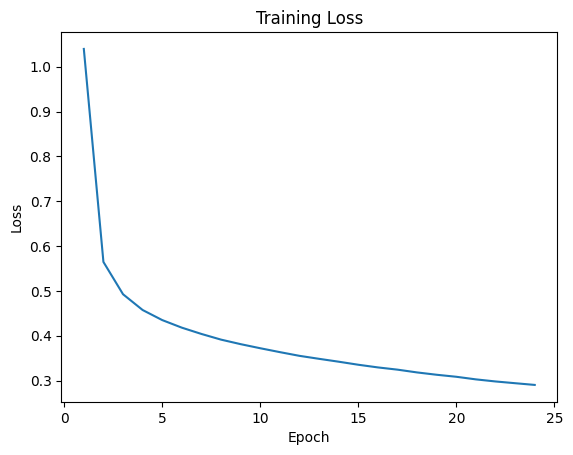

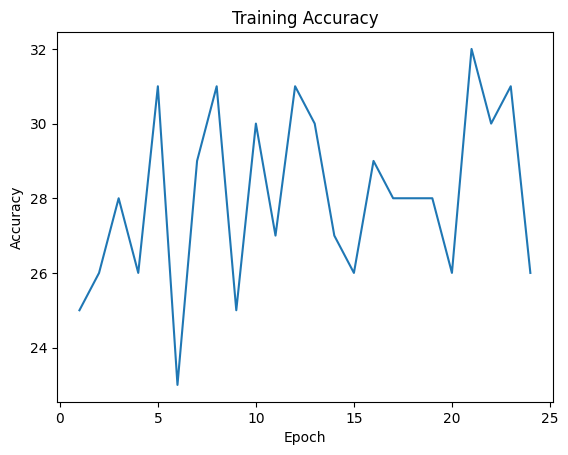

In [2]:
# 导入必要的模块
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 对数据进行预处理，将其转换为张量，并在通道维度上标准化
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 加载 FashionMNIST 数据集
train_dataset = datasets.FashionMNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('data', train=False, download=True, transform=transform)

# 创建 DataLoader，用于加载数据并组成 batch
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# 定义 MLP 模型
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 128)  # 输入层->隐藏层1
        self.fc2 = nn.Linear(128, 64)   # 隐藏层1->隐藏层2
        self.fc3 = nn.Linear(64, 10)    # 隐藏层2->输出层

    def forward(self, x):
        x = x.view(x.size(0), -1)       # 展平输入张量
        x = torch.relu(self.fc1(x))     # relu 激活函数
        x = torch.relu(self.fc2(x))     # relu 激活函数
        x = self.fc3(x)                 # 输出层不需要激活函数
        return x

                       # 实例化模型

for num_epochs in range(25):
    model = MLP()  
    criterion = nn.CrossEntropyLoss()      # 定义损失函数为交叉熵损失
    optimizer = optim.SGD(model.parameters(), lr=0.01)  # 定义优化器为随机梯度下降，学习率为 0.01

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 判断是否有可用的 GPU，有则将模型移动到 GPU 上
    model.to(device)

    # 记录每个 epoch 的训练损失和准确率
    train_losses = []
    train_accuracies = []

    #num_epochs = 10                       # 训练的 epoch 数量
    best_loss = float('inf')              # 设置初始最佳损失值为正无穷大
    patience = 3                          # 设置容忍度为 3，即连续 3 个 epoch 验证集损失没有下降时早停
    counter = 0                           # 记录连续验证集损失没有下降的次数
    for epoch in range(num_epochs):       # 循环每一个 epoch
        running_loss = 0.0               # 记录每个 epoch 的训练损失
        for batch_idx, (images, labels) in enumerate(train_loader):  # 循环每一个 batch
            images = images.to(device)        # 将数据移动到设备上
            labels = labels.to(device)

            optimizer.zero_grad()             # 梯度清零

            outputs = model(images)           # 前向传播，计算模型预测值
            loss = criterion(outputs, labels) # 计算损失
            loss.backward()                   # 反向传播，计算梯度
            optimizer.step()                  # 更新模型参数

            running_loss += loss.item()

            # 计算准确率
            _, predicted = torch.max(outputs.data, 1)
            accuracy = (predicted == labels).sum().item()
            # 打印训练信息
            if (batch_idx+1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                    .format(epoch+1, num_epochs, batch_idx+1, len(train_loader), loss.item(), accuracy*100/labels.size(0)))
        # 在每个 epoch 结束时记录训练损失和准确率
        train_losses.append(running_loss/len(train_loader))
        train_accuracies.append(accuracy)

        # 验证集上进行验证并判断是否早停
        model.eval()  # 切换模型为评估模式
        valid_loss = 0.0
        with torch.no_grad():  # 在验证集上关闭梯度计算
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

        valid_loss /= len(test_loader)
        print('Validation Loss: {:.4f}'.format(valid_loss))

        if valid_loss < best_loss:  # 如果验证集损失下降，则更新最佳损失值，并将计数器重置为 0
            best_loss = valid_loss
            counter = 0
        else:  # 如果验证集损失没有下降，则计数器加 1
            counter += 1

        if counter >= patience:  # 如果连续 patience 次验证集损失没有下降，则进行早停
            print("Early stopping...")
            break

        model.train()  # 切换模型为训练模式

    correct = 0                             # 记录测试集上分类正确的样本数
    total = 0                               # 记录测试集中的总样本数

    with torch.no_grad():                   # 在测试集上关闭梯度计算
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)     # 获取预测结果中最大值所在的索引

            total += labels.size(0)                       # 累计测试集中的样本数量
            correct += (predicted == labels).sum().item()  # 累计分类正确的样本数量

    accuracy = 100 * correct / total          # 计算测试集上的分类准确率
    print(f"Test Accuracy: {accuracy}%")

    # 绘制训练损失曲线
    plt.plot(range(1, num_epochs+1), train_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    # 绘制训练准确率曲线
    plt.plot(range(1, num_epochs+1), train_accuracies)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.show()

c. 从一定角度上看，训练轮数越多，神经网络拟合数据的效果越好，但是相信你也阅读过有关过拟合的资料。那么在上一个小问中，如果我们想增加训练轮数，并且尽量减少过拟合的发生，我们可以有哪些方法？（至少提供两种解决方案，附代码实现，不能调用第三方库）


早停（Early Stopping）：在每个epoch结束时，判断模型在验证集上的性能是否提升，如果没有提升，则停止训练，防止过拟合。可以通过设置一个patience参数来控制连续多少个epoch没有性能提升时停止训练。
对于某个epoch,模型的验证误差逐渐上升，模型出现过拟合，所以需要提前停止训练，早停法主要是训练时间和泛化错误之间的权衡。不同的停止标准也是给我们带来不同的效果。

正则化（Regularization）：通过添加正则化项到损失函数中，惩罚模型的复杂度，防止模型过拟合。常见的正则化方法有L1正则化和L2正则化。


Epoch [1/10], Step [100/938], Loss: 1.8929, Accuracy: 40.62%
Epoch [1/10], Step [200/938], Loss: 1.4353, Accuracy: 48.44%
Epoch [1/10], Step [300/938], Loss: 0.8980, Accuracy: 71.88%
Epoch [1/10], Step [400/938], Loss: 0.8828, Accuracy: 68.75%
Epoch [1/10], Step [500/938], Loss: 0.6395, Accuracy: 75.00%
Epoch [1/10], Step [600/938], Loss: 0.7790, Accuracy: 68.75%
Epoch [1/10], Step [700/938], Loss: 0.6220, Accuracy: 78.12%
Epoch [1/10], Step [800/938], Loss: 0.6391, Accuracy: 75.00%
Epoch [1/10], Step [900/938], Loss: 0.6013, Accuracy: 79.69%
Validation Loss: 0.6351
Epoch [2/10], Step [100/938], Loss: 0.6899, Accuracy: 76.56%
Epoch [2/10], Step [200/938], Loss: 0.5398, Accuracy: 82.81%
Epoch [2/10], Step [300/938], Loss: 0.6158, Accuracy: 78.12%
Epoch [2/10], Step [400/938], Loss: 0.3970, Accuracy: 89.06%
Epoch [2/10], Step [500/938], Loss: 0.5697, Accuracy: 79.69%
Epoch [2/10], Step [600/938], Loss: 0.6120, Accuracy: 75.00%
Epoch [2/10], Step [700/938], Loss: 0.4987, Accuracy: 82.81%


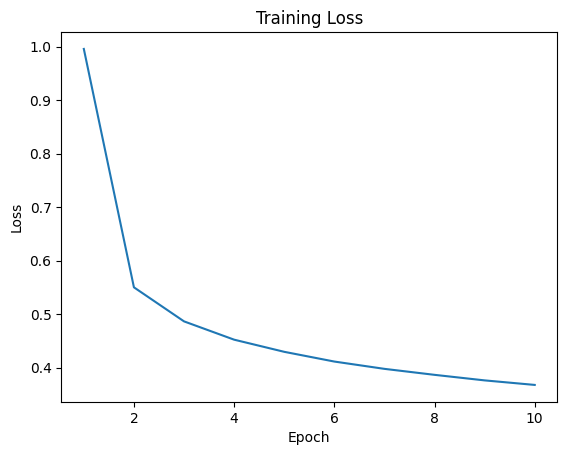

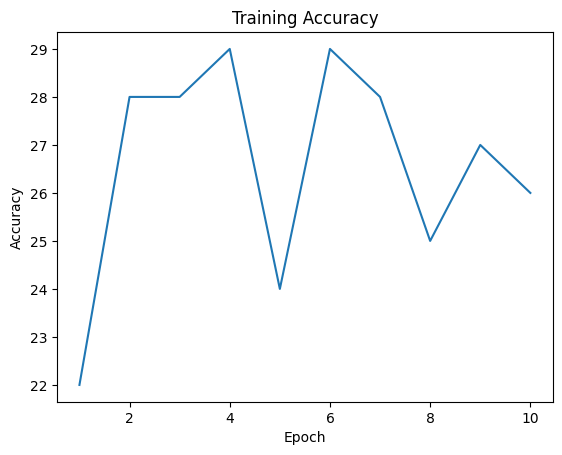

In [3]:
# 导入必要的模块
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 对数据进行预处理，将其转换为张量，并在通道维度上标准化
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 加载 FashionMNIST 数据集
train_dataset = datasets.FashionMNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('data', train=False, download=True, transform=transform)

# 创建 DataLoader，用于加载数据并组成 batch
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# 定义 MLP 模型
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 128)  # 输入层->隐藏层1
        self.fc2 = nn.Linear(128, 64)   # 隐藏层1->隐藏层2
        self.fc3 = nn.Linear(64, 10)    # 隐藏层2->输出层

    def forward(self, x):
        x = x.view(x.size(0), -1)       # 展平输入张量
        x = torch.relu(self.fc1(x))     # relu 激活函数
        x = torch.relu(self.fc2(x))     # relu 激活函数
        x = self.fc3(x)                 # 输出层不需要激活函数
        return x

model = MLP()                         # 实例化模型

criterion = nn.CrossEntropyLoss()      # 定义损失函数为交叉熵损失
optimizer = optim.SGD(model.parameters(), lr=0.01)  # 定义优化器为随机梯度下降，学习率为 0.01

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 判断是否有可用的 GPU，有则将模型移动到 GPU 上
model.to(device)

# 记录每个 epoch 的训练损失和准确率
train_losses = []
train_accuracies = []

num_epochs = 10                       # 训练的 epoch 数量
best_loss = float('inf')              # 设置初始最佳损失值为正无穷大
patience = 3                          # 设置容忍度为 3，即连续 3 个 epoch 验证集损失没有下降时早停
counter = 0                           # 记录连续验证集损失没有下降的次数
for epoch in range(num_epochs):       # 循环每一个 epoch
    running_loss = 0.0               # 记录每个 epoch 的训练损失
    for batch_idx, (images, labels) in enumerate(train_loader):  # 循环每一个 batch
        images = images.to(device)        # 将数据移动到设备上
        labels = labels.to(device)

        optimizer.zero_grad()             # 梯度清零

        outputs = model(images)           # 前向传播，计算模型预测值
        loss = criterion(outputs, labels) # 计算损失
        loss.backward()                   # 反向传播，计算梯度
        optimizer.step()                  # 更新模型参数

        running_loss += loss.item()

        # 计算准确率
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == labels).sum().item()
        # 打印训练信息
        if (batch_idx+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch+1, num_epochs, batch_idx+1, len(train_loader), loss.item(), accuracy*100/labels.size(0)))
    # 在每个 epoch 结束时记录训练损失和准确率
    train_losses.append(running_loss/len(train_loader))
    train_accuracies.append(accuracy)

    # 验证集上进行验证并判断是否早停
    model.eval()  # 切换模型为评估模式
    valid_loss = 0.0
    with torch.no_grad():  # 在验证集上关闭梯度计算
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

    valid_loss /= len(test_loader)
    print('Validation Loss: {:.4f}'.format(valid_loss))

    if valid_loss < best_loss:  # 如果验证集损失下降，则更新最佳损失值，并将计数器重置为 0
        best_loss = valid_loss
        counter = 0
    else:  # 如果验证集损失没有下降，则计数器加 1
        counter += 1

    if counter >= patience:  # 如果连续 patience 次验证集损失没有下降，则进行早停
        print("Early stopping...")
        break

    model.train()  # 切换模型为训练模式

correct = 0                             # 记录测试集上分类正确的样本数
total = 0                               # 记录测试集中的总样本数

with torch.no_grad():                   # 在测试集上关闭梯度计算
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)     # 获取预测结果中最大值所在的索引

        total += labels.size(0)                       # 累计测试集中的样本数量
        correct += (predicted == labels).sum().item()  # 累计分类正确的样本数量

accuracy = 100 * correct / total          # 计算测试集上的分类准确率
print(f"Test Accuracy: {accuracy}%")

# 绘制训练损失曲线
plt.plot(range(1, num_epochs+1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# 绘制训练准确率曲线
plt.plot(range(1, num_epochs+1), train_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.show()

Epoch [1/10], Step [100/938], Loss: 1.8951, Accuracy: 48.44%
Epoch [1/10], Step [200/938], Loss: 1.3574, Accuracy: 65.62%
Epoch [1/10], Step [300/938], Loss: 1.0143, Accuracy: 67.19%
Epoch [1/10], Step [400/938], Loss: 0.8664, Accuracy: 70.31%
Epoch [1/10], Step [500/938], Loss: 0.7161, Accuracy: 71.88%
Epoch [1/10], Step [600/938], Loss: 0.8229, Accuracy: 71.88%
Epoch [1/10], Step [700/938], Loss: 0.8612, Accuracy: 62.50%
Epoch [1/10], Step [800/938], Loss: 0.9426, Accuracy: 62.50%
Epoch [1/10], Step [900/938], Loss: 0.5214, Accuracy: 76.56%
Epoch [2/10], Step [100/938], Loss: 0.5133, Accuracy: 78.12%
Epoch [2/10], Step [200/938], Loss: 0.4384, Accuracy: 82.81%
Epoch [2/10], Step [300/938], Loss: 0.7274, Accuracy: 75.00%
Epoch [2/10], Step [400/938], Loss: 0.5377, Accuracy: 82.81%
Epoch [2/10], Step [500/938], Loss: 0.4942, Accuracy: 81.25%
Epoch [2/10], Step [600/938], Loss: 0.5601, Accuracy: 79.69%
Epoch [2/10], Step [700/938], Loss: 0.5620, Accuracy: 73.44%
Epoch [2/10], Step [800/

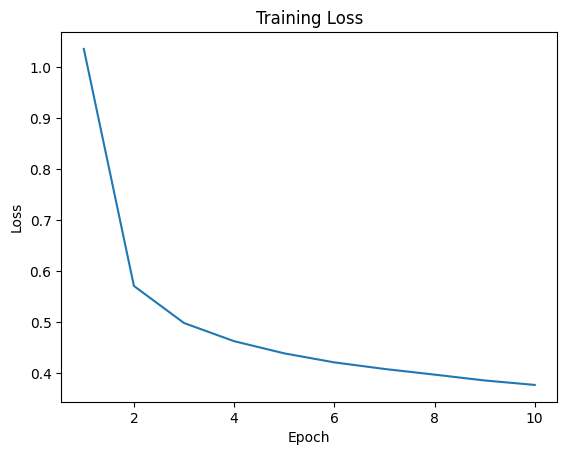

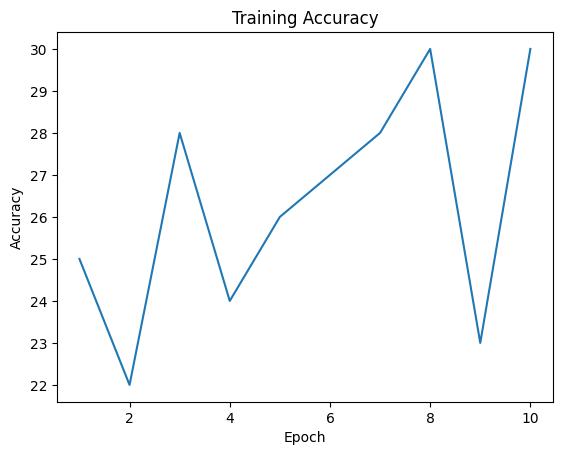

In [4]:
# 导入必要的模块
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 对数据进行预处理，将其转换为张量，并在通道维度上标准化
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 加载 FashionMNIST 数据集
train_dataset = datasets.FashionMNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('data', train=False, download=True, transform=transform)

# 创建 DataLoader，用于加载数据并组成 batch
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# 定义 MLP 模型
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 128)  # 输入层->隐藏层1
        self.fc2 = nn.Linear(128, 64)   # 隐藏层1->隐藏层2
        self.fc3 = nn.Linear(64, 10)    # 隐藏层2->输出层

    def forward(self, x):
        x = x.view(x.size(0), -1)       # 展平输入张量
        x = torch.relu(self.fc1(x))     # relu 激活函数
        x = torch.relu(self.fc2(x))     # relu 激活函数
        x = self.fc3(x)                 # 输出层不需要激活函数
        return x

model = MLP()                         # 实例化模型

criterion = nn.CrossEntropyLoss()      # 定义损失函数为交叉熵损失
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)
  # 定义优化器为随机梯度下降，学习率为 0.01，添加正则化项，权重衰减系数为 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 判断是否有可用的 GPU，有则将模型移动到 GPU 上
model.to(device)

# 记录每个 epoch 的训练损失和准确率
train_losses = []
train_accuracies = []

num_epochs = 10                       # 训练的 epoch 数量
for epoch in range(num_epochs):       # 循环每一个 epoch
    running_loss = 0.0               # 记录每个 epoch 的训练损失
    for batch_idx, (images, labels) in enumerate(train_loader):  # 循环每一个 batch
        images = images.to(device)        # 将数据移动到设备上
        labels = labels.to(device)

        optimizer.zero_grad()             # 梯度清零

        outputs = model(images)           # 前向传播，计算模型预测值
        loss = criterion(outputs, labels) # 计算损失
        loss.backward()                   # 反向传播，计算梯度
        optimizer.step()                  # 更新模型参数

        running_loss += loss.item()

        # 计算准确率
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == labels).sum().item()
        # 打印训练信息
        if (batch_idx+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch+1, num_epochs, batch_idx+1, len(train_loader), loss.item(), accuracy*100/labels.size(0)))
    # 在每个 epoch 结束时记录训练损失和准确率
    train_losses.append(running_loss/len(train_loader))
    train_accuracies.append(accuracy)
    # for images, labels in train_loader:  # 循环每一个 batch
    #     images = images.to(device)        # 将数据移动到设备上
    #     labels = labels.to(device)

    #     optimizer.zero_grad()             # 梯度清零

    #     outputs = model(images)           # 前向传播，计算模型预测值
    #     loss = criterion(outputs, labels) # 计算损失
    #     loss.backward()                   # 反向传播，计算梯度
    #     optimizer.step()                  # 更新模型参数

    #     running_loss += loss.item()

    #     # 计算准确率
    #     _, predicted = torch.max(outputs.data, 1)
    #     accuracy = (predicted == labels).sum().item()

    # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

correct = 0                             # 记录测试集上分类正确的样本数
total = 0                               # 记录测试集中的总样本数

with torch.no_grad():                   # 在测试集上关闭梯度计算
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)     # 获取预测结果中最大值所在的索引

        total += labels.size(0)                       # 累计测试集中的样本数量
        correct += (predicted == labels).sum().item()  # 累计分类正确的样本数量

accuracy = 100 * correct / total          # 计算测试集上的分类准确率
print(f"Test Accuracy: {accuracy}%")

# 绘制训练损失曲线
plt.plot(range(1, num_epochs+1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# 绘制训练准确率曲线
plt.plot(range(1, num_epochs+1), train_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.show()


d. 激活函数在神经网络的各层之间的作用是非常关键的，请你尝试不同的激活函数，看看其对最终的结果是否造成一定影响。
激活函数对神经网络的性能有显著影响

In [6]:
# 导入必要的模块
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 对数据进行预处理，将其转换为张量，并在通道维度上标准化
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 加载 FashionMNIST 数据集
train_dataset = datasets.FashionMNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('data', train=False, download=True, transform=transform)

# 创建 DataLoader，用于加载数据并组成 batch
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

class MLP(nn.Module):
    def __init__(self, activation='relu'):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'tanh':
            self.activation = nn.Tanh()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

activations = ['relu', 'sigmoid', 'tanh']
train_losses = {}
train_accuracies = {}
test_losses = {}
test_accuracies = {}
for activation in activations:
    model = MLP(activation).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    train_losses_activation = []
    train_accuracies_activation = []
    test_losses_activation = []
    test_accuracies_activation = []
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = test(model, test_loader, criterion, device)
        train_losses_activation.append(train_loss)
        train_accuracies_activation.append(train_acc)
        test_losses_activation.append(test_loss)
        test_accuracies_activation.append(test_acc)
        print(f"Activation: {activation}, Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    train_losses[activation] = train_losses_activation
    train_accuracies[activation] = train_accuracies_activation
    test_losses[activation] = test_losses_activation
    test_accuracies[activation] = test_accuracies_activation

# 保存实验结果
torch.save({
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'test_losses': test_losses,
    'test_accuracies': test_accuracies
}, 'activation_experiment_results.pth')

Activation: relu, Epoch 1/10, Train Loss: 1.0020, Train Acc: 0.6700, Test Loss: 0.6454, Test Acc: 0.7609
Activation: relu, Epoch 2/10, Train Loss: 0.5599, Train Acc: 0.7984, Test Loss: 0.5515, Test Acc: 0.8016
Activation: relu, Epoch 3/10, Train Loss: 0.4916, Train Acc: 0.8247, Test Loss: 0.5057, Test Acc: 0.8148
Activation: relu, Epoch 4/10, Train Loss: 0.4569, Train Acc: 0.8368, Test Loss: 0.4793, Test Acc: 0.8294
Activation: relu, Epoch 5/10, Train Loss: 0.4347, Train Acc: 0.8443, Test Loss: 0.4728, Test Acc: 0.8237
Activation: relu, Epoch 6/10, Train Loss: 0.4169, Train Acc: 0.8519, Test Loss: 0.4466, Test Acc: 0.8378
Activation: relu, Epoch 7/10, Train Loss: 0.4019, Train Acc: 0.8563, Test Loss: 0.4396, Test Acc: 0.8434
Activation: relu, Epoch 8/10, Train Loss: 0.3892, Train Acc: 0.8606, Test Loss: 0.4249, Test Acc: 0.8473
Activation: relu, Epoch 9/10, Train Loss: 0.3788, Train Acc: 0.8647, Test Loss: 0.4132, Test Acc: 0.8494
Activation: relu, Epoch 10/10, Train Loss: 0.3678, Trai

容易看出relu和tanh近似，sigmoid的准确率显著下降

在⼀次⽹络的训练过程中，我们会经历数据的输⼊输出以及梯度回传过程，在输⼊数据的时候
我们通常会将⼀个⼩批次数据打包然后统⼀放⼊⽹络训练，这种做法称为minibatch⽅法，请你
研究不同batch下的优化过程，提出不同的batch⼤⼩如何造成这样的训练效果，简单从数据和
优化的⻆度来叙述

数据方面：
大批量：使用较大的批量进行训练可以有效利用计算资源，加快训练速度。大批量训练可以提供更多的样本信息，使得模型更稳定，减少了随机性，从而有助于更快地收敛到全局最优解。然而，大批量训练所需的存储空间和计算资源也更多。
小批量：使用较小的批量进行训练可以增加随机性，提供更多的样本变化，有助于避免陷入局部最优解。小批量训练可以提高模型的泛化能力，减少过拟合的风险。此外，小批量训练可以在训练过程中更频繁地更新模型参数，使得模型更具鲁棒性。但是，小批量训练可能导致训练过程中的噪声增加，并且可能需要更长的训练时间。
优化方面：
大批量：使用大批量训练时，梯度的估计更加准确和稳定，因为梯度是由一批样本的平均梯度计算得到的。这可以使模型参数更快地朝着全局最优解的方向更新。然而，大批量训练可能会导致陷入局部最优解的风险增加，并且可能出现模型过拟合的情况。
小批量：使用小批量训练时，梯度的估计更加不准确和不稳定，因为梯度是由少量样本的平均梯度计算得到的。这可以使模型参数在训练过程中更具随机性，有助于跳出局部最优解并探索更广阔的解空间。然而，小批量训练可能会导致训练过程中的震荡和不稳定，需要更小的学习率和更多的训练迭代次数来收敛到合适的解。

100.0%


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100.0%

Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw

Batch Size: 64
Epoch [1/10], Step [100/938], Loss: 2.0120, Accuracy: 32.81%
Epoch [1/10], Step [200/938], Loss: 1.4323, Accuracy: 62.50%
Epoch [1/10], Step [300/938], Loss: 0.9365, Accuracy: 78.12%
Epoch [1/10], Step [400/938], Loss: 0.8402, Accuracy: 76.56%
Epoch [1/10], Step [500/938], Loss: 0.7998, Accuracy: 68.75%
Epoch [1/10], Step [600/938], Loss: 0.8781, Accuracy: 65.62%
Epoch [1/10], Step [700/938], Loss: 0.6207, Accuracy: 79.69%
Epoch [1/10], Step [800/938], Loss: 0.6257, Accuracy: 79.69%
Epoch [1/10], Step [900/938], Loss: 0.6463, Accuracy: 73.44%
Epoch [2/10], Step [100/938], Loss: 0.5569, Accuracy: 78.12%
Epoch [2/10], Step [200/938], Loss: 0.4493, Accuracy: 82.81%
Epoch [2/10], Step [300/938], Loss: 0.5327, Accuracy: 82.81%
Epoch [2/10], Step [400/938], Loss: 0.7055, Accuracy: 73.44%
Epoch [2/10], Step [500/938], Loss: 0.2785, Accuracy: 89.06%
Epoch [2/10], Step [600/938], Loss: 0.5193, Ac

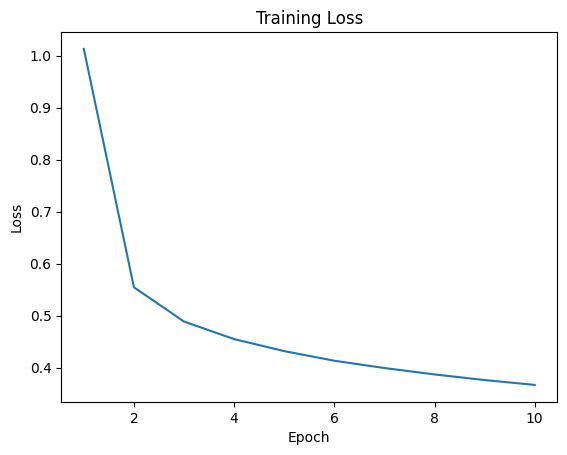

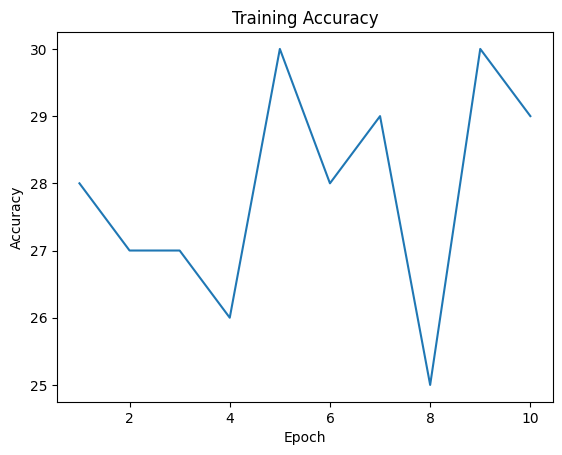

Batch Size: 128
Epoch [1/10], Step [100/469], Loss: 1.8266, Accuracy: 56.25%
Epoch [1/10], Step [200/469], Loss: 1.2507, Accuracy: 62.50%
Epoch [1/10], Step [300/469], Loss: 0.9973, Accuracy: 71.88%
Epoch [1/10], Step [400/469], Loss: 0.7836, Accuracy: 77.34%
Epoch [2/10], Step [100/469], Loss: 0.7203, Accuracy: 76.56%
Epoch [2/10], Step [200/469], Loss: 0.7353, Accuracy: 75.78%
Epoch [2/10], Step [300/469], Loss: 0.6906, Accuracy: 77.34%
Epoch [2/10], Step [400/469], Loss: 0.6328, Accuracy: 75.00%
Epoch [3/10], Step [100/469], Loss: 0.5708, Accuracy: 78.12%
Epoch [3/10], Step [200/469], Loss: 0.6984, Accuracy: 70.31%
Epoch [3/10], Step [300/469], Loss: 0.6549, Accuracy: 75.78%
Epoch [3/10], Step [400/469], Loss: 0.5220, Accuracy: 81.25%
Epoch [4/10], Step [100/469], Loss: 0.5151, Accuracy: 81.25%
Epoch [4/10], Step [200/469], Loss: 0.5173, Accuracy: 80.47%
Epoch [4/10], Step [300/469], Loss: 0.4642, Accuracy: 85.16%
Epoch [4/10], Step [400/469], Loss: 0.6394, Accuracy: 77.34%
Epoch [5

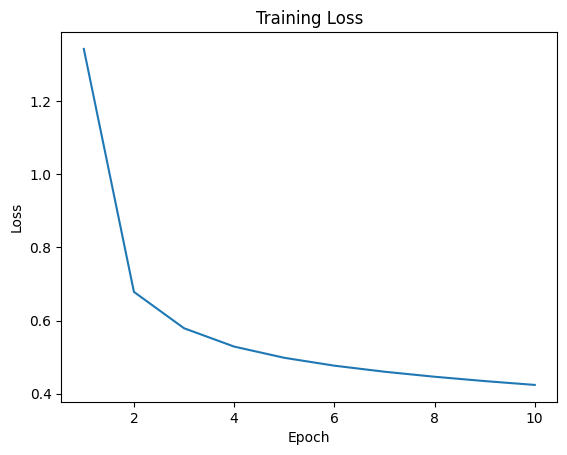

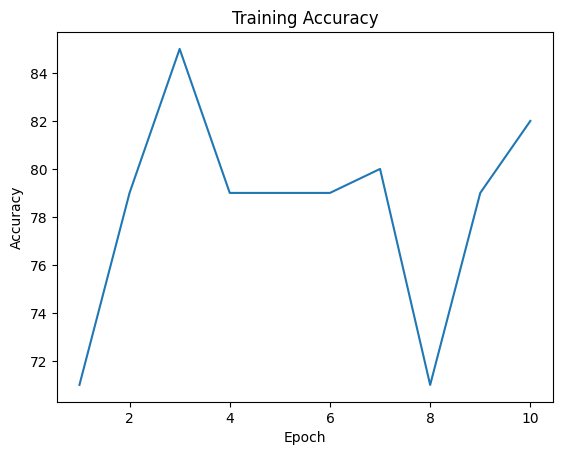

Batch Size: 256
Epoch [1/10], Step [100/235], Loss: 1.9643, Accuracy: 48.83%
Epoch [1/10], Step [200/235], Loss: 1.3064, Accuracy: 73.83%
Epoch [2/10], Step [100/235], Loss: 0.9244, Accuracy: 73.83%
Epoch [2/10], Step [200/235], Loss: 0.8937, Accuracy: 70.70%
Epoch [3/10], Step [100/235], Loss: 0.7425, Accuracy: 76.17%
Epoch [3/10], Step [200/235], Loss: 0.7105, Accuracy: 74.22%
Epoch [4/10], Step [100/235], Loss: 0.6649, Accuracy: 75.78%
Epoch [4/10], Step [200/235], Loss: 0.5739, Accuracy: 81.25%
Epoch [5/10], Step [100/235], Loss: 0.5900, Accuracy: 75.78%
Epoch [5/10], Step [200/235], Loss: 0.4518, Accuracy: 83.59%
Epoch [6/10], Step [100/235], Loss: 0.6831, Accuracy: 76.17%
Epoch [6/10], Step [200/235], Loss: 0.4903, Accuracy: 80.86%
Epoch [7/10], Step [100/235], Loss: 0.5884, Accuracy: 78.52%
Epoch [7/10], Step [200/235], Loss: 0.5276, Accuracy: 81.64%
Epoch [8/10], Step [100/235], Loss: 0.4931, Accuracy: 82.81%
Epoch [8/10], Step [200/235], Loss: 0.4545, Accuracy: 84.38%
Epoch [9

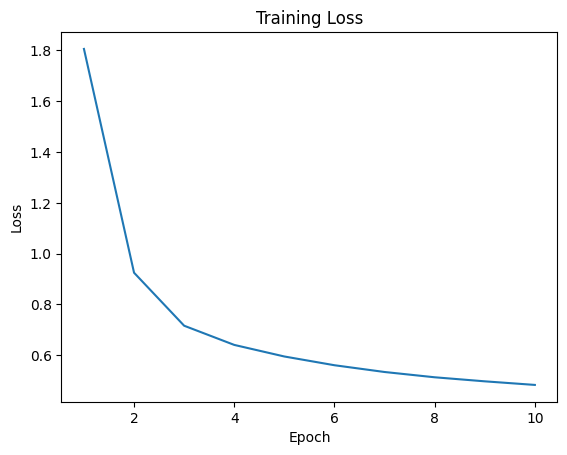

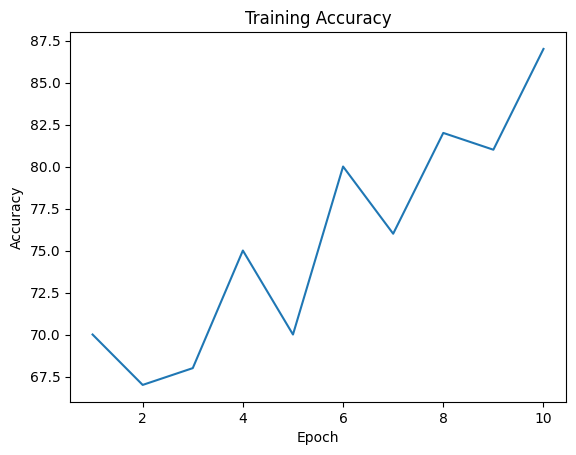

Batch Size: 512
Epoch [1/10], Step [100/118], Loss: 1.8879, Accuracy: 47.85%
Epoch [2/10], Step [100/118], Loss: 1.2658, Accuracy: 64.65%
Epoch [3/10], Step [100/118], Loss: 0.9313, Accuracy: 72.46%
Epoch [4/10], Step [100/118], Loss: 0.7722, Accuracy: 74.22%
Epoch [5/10], Step [100/118], Loss: 0.7251, Accuracy: 75.20%
Epoch [6/10], Step [100/118], Loss: 0.6821, Accuracy: 76.56%
Epoch [7/10], Step [100/118], Loss: 0.5860, Accuracy: 79.30%
Epoch [8/10], Step [100/118], Loss: 0.5840, Accuracy: 80.08%
Epoch [9/10], Step [100/118], Loss: 0.5743, Accuracy: 80.27%
Epoch [10/10], Step [100/118], Loss: 0.6036, Accuracy: 78.12%
Test Accuracy: 77.75%


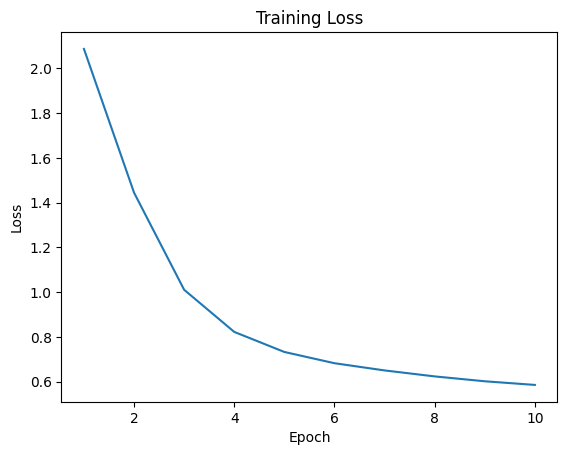

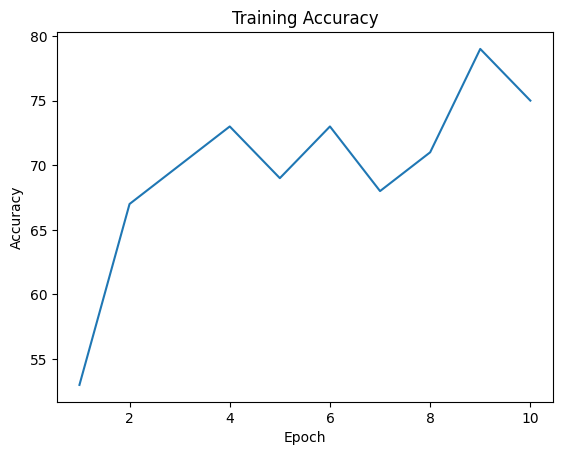

Batch Size: 1024
Test Accuracy: 74.58%


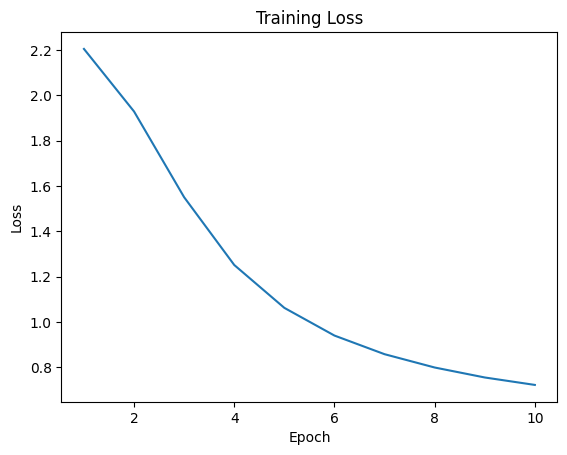

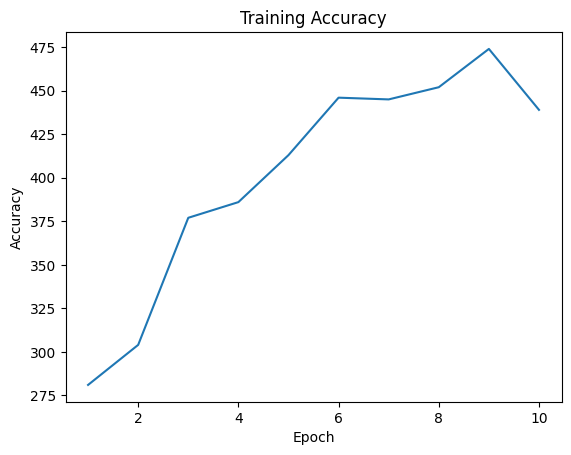

In [1]:
# 导入必要的模块
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 对数据进行预处理，将其转换为张量，并在通道维度上标准化
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 加载 FashionMNIST 数据集
train_dataset = datasets.FashionMNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('data', train=False, download=True, transform=transform)
for batch_size in [64, 128, 256, 512, 1024]:
    print(f"Batch Size: {batch_size}")
    # 创建 DataLoader，用于加载数据并组成 batch
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

    # 定义 MLP 模型
    class MLP(nn.Module):
        def __init__(self):
            super(MLP, self).__init__()
            self.fc1 = nn.Linear(784, 128)  # 输入层->隐藏层1
            self.fc2 = nn.Linear(128, 64)   # 隐藏层1->隐藏层2
            self.fc3 = nn.Linear(64, 10)    # 隐藏层2->输出层

        def forward(self, x):
            x = x.view(x.size(0), -1)       # 展平输入张量
            x = torch.relu(self.fc1(x))     # relu 激活函数
            x = torch.relu(self.fc2(x))     # relu 激活函数
            x = self.fc3(x)                 # 输出层不需要激活函数
            return x

    model = MLP()                         # 实例化模型

    criterion = nn.CrossEntropyLoss()      # 定义损失函数为交叉熵损失
    optimizer = optim.SGD(model.parameters(), lr=0.01)  # 定义优化器为随机梯度下降，学习率为 0.01

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 判断是否有可用的 GPU，有则将模型移动到 GPU 上
    model.to(device)

    # 记录每个 epoch 的训练损失和准确率
    train_losses = []
    train_accuracies = []

    num_epochs = 10                       # 训练的 epoch 数量
    for epoch in range(num_epochs):       # 循环每一个 epoch
        running_loss = 0.0               # 记录每个 epoch 的训练损失
        for batch_idx, (images, labels) in enumerate(train_loader):  # 循环每一个 batch
            images = images.to(device)        # 将数据移动到设备上
            labels = labels.to(device)

            optimizer.zero_grad()             # 梯度清零

            outputs = model(images)           # 前向传播，计算模型预测值
            loss = criterion(outputs, labels) # 计算损失
            loss.backward()                   # 反向传播，计算梯度
            optimizer.step()                  # 更新模型参数

            running_loss += loss.item()

            # 计算准确率
            _, predicted = torch.max(outputs.data, 1)
            accuracy = (predicted == labels).sum().item()
            # 打印训练信息
            if (batch_idx+1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                    .format(epoch+1, num_epochs, batch_idx+1, len(train_loader), loss.item(), accuracy*100/labels.size(0)))
        # 在每个 epoch 结束时记录训练损失和准确率
        train_losses.append(running_loss/len(train_loader))
        train_accuracies.append(accuracy)


    correct = 0                             # 记录测试集上分类正确的样本数
    total = 0                               # 记录测试集中的总样本数

    with torch.no_grad():                   # 在测试集上关闭梯度计算
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)     # 获取预测结果中最大值所在的索引

            total += labels.size(0)                       # 累计测试集中的样本数量
            correct += (predicted == labels).sum().item()  # 累计分类正确的样本数量

    accuracy = 100 * correct / total          # 计算测试集上的分类准确率
    print(f"Test Accuracy: {accuracy}%")

    # 绘制训练损失曲线
    plt.plot(range(1, num_epochs+1), train_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    # 绘制训练准确率曲线
    plt.plot(range(1, num_epochs+1), train_accuracies)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.show()